### Regression with MLP on waiting times dataset

In [ ]:
import matplotlib.pyplot as plt
import os.path
import numpy as np
import sys
from typing import Callable, Dict, Any, Tuple, Optional

sys.path.append('../..') # Adds the parent directory to the path

from Data.datasets.WaitPark import WaitPark

from Helpers.NeuralNetwork import NeuralNetwork
from Helpers.trainNN import train_network

from Helpers import Helpers
from Layers.FullyConnected import FullyConnected
from Layers.Dropout import Dropout
from Layers.Activations import ReLU, LeakyReLU, ELU, Sigmoid, TanH, Swish, GELU
from Layers.Initializers import He, Constant, Xavier

from Optimization.Optimizers import Adam
from Optimization.Loss import MSELoss
from Optimization.Constraints import L2_Regularizer

In [ ]:
# Charger les données WaitPark
batch_size = 32
waitpark = WaitPark(batch_size, include_weather=True)
waitpark.print_dataset_info()


dataset Informations:
--------------------------------------------------
Training samples: 25912
Sample shape: (28,)
Number of classes: 1
Test samples: 5554
Dataset size in memory: 6.72 MB

----------------------------------------------------------------------------------------------------
Train Sample 24253: Unknown - Target Wait Time in 2 Hours: 25.0 minutes
----------------------------------------------------------------------------------------------------

                           DATETIME ENTITY_DESCRIPTION_SHORT ADJUST_CAPACITY       DOWNTIME CURRENT_WAIT_TIME TIME_TO_PARADE_1 TIME_TO_PARADE_2 TIME_TO_NIGHT_SHOW WAIT_TIME_IN_2H          HOUR MINUTE  TIME_MINUTES DAY_OF_WEEK         MONTH           YEAR           DAY        DATE           temp      dew_point     feels_like       pressure      humidity     wind_speed rain_1h snow_1h    clouds_all
Type                                                                                                                                  

### Plusieurs architectures de modèles à tester

In [ ]:
# ================================
# VARIANTES DE MODÈLES DE RÉGRESSION
# ================================

def build_simple_shallow_model(input_dim, output_dim):
    """
    🏗️ MODÈLE SIMPLE & LÉGER
    - 1 couche cachée de 32 neurones
    - Activation ReLU basique
    - Faible régularisation
    - Idéal pour : datasets simples, apprentissage rapide
    """
    learning_rate = 0.01
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.0001)  # Très faible régularisation
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = Xavier()  # Xavier pour réseaux peu profonds
    bias_initializer = Constant(0.0)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture minimaliste
    net.append_layer(FullyConnected(input_dim, 32))
    net.append_layer(ReLU())
    net.append_layer(FullyConnected(32, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_deep_wide_model(input_dim, output_dim):
    """
    🏢 MODÈLE PROFOND & LARGE
    - 4 couches cachées (256, 128, 64, 32)
    - Capacité d'apprentissage élevée
    - Régularisation modérée
    - Idéal pour : datasets complexes, relations non-linéaires
    """
    learning_rate = 0.0005  # Plus lent pour la stabilité
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.01)  # Régularisation plus forte
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture large et profonde
    net.append_layer(FullyConnected(input_dim, 256))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(256, 128))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(128, 64))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(64, 32))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(32, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_dropout_robust_model(input_dim, output_dim):
    """
    🛡️ MODÈLE AVEC DROPOUT ROBUSTE
    - Dropout après chaque couche cachée
    - Protection contre le surapprentissage
    - Architecture équilibrée
    - Idéal pour : prévenir l'overfitting, généralisation
    """
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.005)
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture avec dropout
    net.append_layer(FullyConnected(input_dim, 128))
    net.append_layer(ReLU())
    net.append_layer(Dropout(0.3))  # 30% de dropout
    
    net.append_layer(FullyConnected(128, 64))
    net.append_layer(ReLU())
    net.append_layer(Dropout(0.2))  # 20% de dropout
    
    net.append_layer(FullyConnected(64, 32))
    net.append_layer(ReLU())
    net.append_layer(Dropout(0.1))  # 10% de dropout
    
    net.append_layer(FullyConnected(32, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_leaky_relu_model(input_dim, output_dim):
    """
    ⚡ MODÈLE AVEC LEAKY RELU
    - Activation LeakyReLU pour éviter les neurones morts
    - Apprentissage plus stable
    - Gradient non-nul pour valeurs négatives
    - Idéal pour : problèmes avec gradients qui disparaissent
    """
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.001)
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture avec LeakyReLU
    net.append_layer(FullyConnected(input_dim, 128))
    net.append_layer(LeakyReLU(alpha=0.01))  # Pente de 0.01 pour valeurs négatives
    
    net.append_layer(FullyConnected(128, 64))
    net.append_layer(LeakyReLU(alpha=0.01))
    
    net.append_layer(FullyConnected(64, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_tanh_model(input_dim, output_dim):
    """
    🌊 MODÈLE AVEC ACTIVATION TANH
    - Activation Tanh (sortie entre -1 et 1)
    - Centré sur zéro
    - Meilleur pour certains types de données
    - Idéal pour : données normalisées, convergence rapide
    """
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.001)
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = Xavier()  # Xavier recommandé pour Tanh
    bias_initializer = Constant(0.0)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture avec Tanh
    net.append_layer(FullyConnected(input_dim, 128))
    net.append_layer(TanH())
    
    net.append_layer(FullyConnected(128, 64))
    net.append_layer(TanH())
    
    net.append_layer(FullyConnected(64, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_high_learning_rate_model(input_dim, output_dim):
    """
    🚀 MODÈLE APPRENTISSAGE RAPIDE
    - Taux d'apprentissage élevé
    - Convergence plus rapide
    - Risque d'instabilité
    - Idéal pour : expérimentation rapide, datasets simples
    """
    learning_rate = 0.01  # 10x plus élevé
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.001)
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture standard mais apprentissage rapide
    net.append_layer(FullyConnected(input_dim, 128))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(128, 64))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(64, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_no_regularization_model(input_dim, output_dim):
    """
    🎯 MODÈLE SANS RÉGULARISATION
    - Aucune régularisation L2
    - Capacité maximale d'apprentissage
    - Risque de surapprentissage
    - Idéal pour : datasets avec beaucoup de données, baseline
    """
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    # Pas de régularisation
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture identique au modèle original
    net.append_layer(FullyConnected(input_dim, 128))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(128, 64))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(64, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_narrow_deep_model(input_dim, output_dim):
    """
    🏗️ MODÈLE ÉTROIT & PROFOND
    - Couches étroites (64 neurones max)
    - Réseau profond (5 couches cachées)
    - Spécialisation progressive
    - Idéal pour : extraction de caractéristiques complexes
    """
    learning_rate = 0.0008
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.005)
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture étroite et profonde
    net.append_layer(FullyConnected(input_dim, 64))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(64, 64))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(64, 32))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(32, 16))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(16, 8))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(8, output_dim))
    
    net.loss_layer = MSELoss()
    return net

def build_ensemble_friendly_model(input_dim, output_dim):
    """
    🎭 MODÈLE POUR ENSEMBLE
    - Architecture modérée avec randomisation
    - Bonne pour combinaison avec d'autres modèles
    - Équilibre biais-variance
    - Idéal pour : techniques d'ensemble, bagging
    """
    learning_rate = 0.002  # Légèrement plus élevé
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.008)  # Régularisation modérée
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.2)  # Biais légèrement plus élevé
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Architecture avec dimensions légèrement différentes
    net.append_layer(FullyConnected(input_dim, 96))  # Taille non-standard
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(96, 48))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(48, 24))
    net.append_layer(ReLU())
    
    net.append_layer(FullyConnected(24, output_dim))
    
    net.loss_layer = MSELoss()
    return net

## 📊 Analyse des Résidus

### Définition
Un **résidu** est l'écart entre la valeur observée et prédite :
$$\varepsilon_i = y_i - \hat{y}_i$$

### Propriétés clés
- **Variance** : $\sigma^2_\varepsilon = \frac{1}{n-p} \sum \varepsilon_i^2$
- **Indépendance** : $Cov(\varepsilon_i, \varepsilon_j) = 0$ pour $i \neq j$

### Métriques importantes
- **MSE** : $MSE = \frac{1}{n} \sum \varepsilon_i^2$
- **RMSE** : $RMSE = \sqrt{MSE}$
- **MAE** : $MAE = \frac{1}{n} \sum |\varepsilon_i|$
- **R²** : $R^2 = 1 - \frac{\sum \varepsilon_i^2}{\sum (y_i - \bar{y})^2}$

### Hypothèses fondamentales
1. **Normalité** : $\varepsilon_i \sim N(0, \sigma^2)$
2. **Homoscédasticité** : variance constante
3. **Linéarité** : $E[\varepsilon_i|X] = 0$
4. **Indépendance** : pas d'autocorrélation

### Diagnostic graphique
- **✅ Bon modèle** : Résidus dispersés aléatoirement autour de $y=0$
- **❌ Problème** : Patterns courbes, tendances, hétéroscédasticité
- **❌ Sur-apprentissage** : Résidus faibles (train) vs élevés (test)

### Interprétation
- **Résidus aléatoires** → Modèle bien ajusté
- **Patterns systématiques** → Variables omises ou non-linéarités
- **Variance croissante** → Hétéroscédasticité
- **Valeurs extrêmes** → Outliers ou points influents

In [ ]:
def analyze_and_visualize_regression_model(
    model_builder: Callable,
    waitpark_data,
    iterations: int = 10000,
    metrics_interval: int = 50,
    figsize: Tuple[int, int] = (15, 12),
    plot_prefix: str = "regression_analysis"
) -> Dict[str, Any]:
    """
    Fonction complète pour entraîner et analyser un modèle de régression avec visualisations.
    
    Args:
        model_builder: Fonction qui construit le modèle (ex: build_regression_model)
        waitpark_data: Dataset préprocessé
        iterations: Nombre d'itérations d'entraînement
        metrics_interval: Intervalle pour calculer les métriques
        figsize: Taille des figures
        plot_prefix: Préfixe pour les noms de fichiers sauvegardés
    
    Returns:
        Dict contenant le modèle, les métriques et l'historique
    """
    
    # 1. Construire et entraîner le modèle
    print("🔧 Construction du modèle...")
    input_shape = waitpark_data._input_tensor.shape[1]
    output_shape = 1
    
    model = model_builder(input_dim=input_shape, output_dim=output_shape)
    model.plot()
    model.data_layer = waitpark_data
    
    print(f"📊 Entraînement du modèle ({iterations} itérations)...")
    history = train_network(model, iterations, metrics_interval=metrics_interval)
    
    # 2. Évaluation sur l'ensemble de test
    print("🎯 Évaluation sur l'ensemble de test...")
    test_data, test_labels = waitpark_data.get_test_set()
    test_predictions = model.test(test_data)
    test_metrics = Helpers.calculate_regression_metrics(test_predictions, test_labels)
    
    # Afficher les métriques
    print("\n📈 Métriques sur l'ensemble de test:")
    print(f"MSE: {test_metrics['mse']:.4f}")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"R²: {test_metrics['r_squared']:.4f}")
    print(f"Variance expliquée: {test_metrics['explained_variance']:.4f}")
    
    # 3. Créer les visualisations
    print("📊 Génération des visualisations...")
    _create_comprehensive_plots(
        test_labels, test_predictions, history, 
        figsize, plot_prefix
    )
    
    return {
        'model': model,
        'test_metrics': test_metrics,
        'test_predictions': test_predictions,
        'test_labels': test_labels,
        'history': history
    }

def _create_comprehensive_plots(
    test_labels, test_predictions, history, 
    figsize, plot_prefix
):
    """Crée tous les graphiques d'analyse."""
    
    # Figure 1: Analyse des prédictions (2x2 subplots)
    fig1, axes1 = plt.subplots(2, 2, figsize=figsize)
    
    # Subplot 1: Prédictions vs Valeurs réelles
    axes1[0, 0].scatter(test_labels, test_predictions, alpha=0.6, color='blue', s=30)
    max_val = max(test_labels.max(), test_predictions.max())
    axes1[0, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    axes1[0, 0].set_xlabel('Temps d\'attente réel (minutes)')
    axes1[0, 0].set_ylabel('Temps d\'attente prédit (minutes)')
    axes1[0, 0].set_title('Prédictions vs Valeurs réelles')
    axes1[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Distribution des erreurs
    errors = test_predictions - test_labels
    axes1[0, 1].hist(errors, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes1[0, 1].axvline(errors.mean(), color='red', linestyle='--', 
                       label=f'Moyenne: {errors.mean():.2f}')
    axes1[0, 1].set_xlabel('Erreur de prédiction (minutes)')
    axes1[0, 1].set_ylabel('Nombre d\'échantillons')
    axes1[0, 1].set_title('Distribution des erreurs')
    axes1[0, 1].grid(True, alpha=0.3)
    axes1[0, 1].legend()
    
    # Subplot 3: Erreurs relatives (en pourcentage)
    relative_errors = np.abs(errors) / (test_labels + 1e-8) * 100  # Éviter division par 0
    axes1[1, 0].hist(relative_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes1[1, 0].set_xlabel('Erreur relative (%)')
    axes1[1, 0].set_ylabel('Nombre d\'échantillons')
    axes1[1, 0].set_title('Distribution des erreurs relatives')
    axes1[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Analyse des résidus
    axes1[1, 1].scatter(test_predictions, errors, alpha=0.6, color='purple', s=30)
    axes1[1, 1].axhline(y=0, color='red', linestyle='--')
    axes1[1, 1].set_xlabel('Prédictions')
    axes1[1, 1].set_ylabel('Résidus')
    axes1[1, 1].set_title('Analyse des résidus')
    axes1[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Évolution des métriques pendant l'entraînement
    if 'train_metrics' in history and history['train_metrics']:
        _plot_training_metrics(history, figsize, plot_prefix)


def _plot_training_metrics(history, figsize, plot_prefix):
    """Crée les graphiques d'évolution des métriques d'entraînement."""
    
    # Extraire les métriques
    train_mse = [metrics['mse'] for metrics in history['train_metrics']]
    train_rmse = [metrics['rmse'] for metrics in history['train_metrics']]
    train_mae = [metrics.get('mae', 0) for metrics in history['train_metrics']]
    train_r2 = [metrics['r_squared'] for metrics in history['train_metrics']]
    
    # Vérifier les métriques de validation
    has_val = 'val_metrics' in history and history['val_metrics']
    if has_val:
        val_mse = [metrics['mse'] for metrics in history['val_metrics']]
        val_rmse = [metrics['rmse'] for metrics in history['val_metrics']]
        val_mae = [metrics.get('mae', 0) for metrics in history['val_metrics']]
        val_r2 = [metrics['r_squared'] for metrics in history['val_metrics']]
    
    # Créer la figure avec subplots
    fig2, axes2 = plt.subplots(2, 2, figsize=figsize)
    
    # MSE
    axes2[0, 0].plot(history['iterations'], train_mse, 'b-', label='Train MSE', linewidth=2)
    if has_val:
        axes2[0, 0].plot(history['iterations'], val_mse, 'r-', label='Validation MSE', linewidth=2)
    axes2[0, 0].set_title('MSE pendant l\'entraînement')
    axes2[0, 0].set_xlabel('Itérations')
    axes2[0, 0].set_ylabel('MSE')
    axes2[0, 0].grid(True, alpha=0.3)
    axes2[0, 0].legend()
    
    # RMSE
    axes2[0, 1].plot(history['iterations'], train_rmse, 'b-', label='Train RMSE', linewidth=2)
    if has_val:
        axes2[0, 1].plot(history['iterations'], val_rmse, 'r-', label='Validation RMSE', linewidth=2)
    axes2[0, 1].set_title('RMSE pendant l\'entraînement')
    axes2[0, 1].set_xlabel('Itérations')
    axes2[0, 1].set_ylabel('RMSE')
    axes2[0, 1].grid(True, alpha=0.3)
    axes2[0, 1].legend()
    
    # MAE
    if any(mae > 0 for mae in train_mae):  # Vérifier si MAE est disponible
        axes2[1, 0].plot(history['iterations'], train_mae, 'b-', label='Train MAE', linewidth=2)
        if has_val and any(mae > 0 for mae in val_mae):
            axes2[1, 0].plot(history['iterations'], val_mae, 'r-', label='Validation MAE', linewidth=2)
        axes2[1, 0].set_title('MAE pendant l\'entraînement')
        axes2[1, 0].set_xlabel('Itérations')
        axes2[1, 0].set_ylabel('MAE')
        axes2[1, 0].grid(True, alpha=0.3)
        axes2[1, 0].legend()
    else:
        axes2[1, 0].text(0.5, 0.5, 'MAE non disponible', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes2[1, 0].transAxes)
        axes2[1, 0].set_title('MAE pendant l\'entraînement')
    
    # R²
    axes2[1, 1].plot(history['iterations'], train_r2, 'b-', label='Train R²', linewidth=2)
    if has_val:
        axes2[1, 1].plot(history['iterations'], val_r2, 'r-', label='Validation R²', linewidth=2)
    axes2[1, 1].set_title('R² pendant l\'entraînement')
    axes2[1, 1].set_xlabel('Itérations')
    axes2[1, 1].set_ylabel('R²')
    axes2[1, 1].grid(True, alpha=0.3)
    axes2[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Fonction utilitaire pour comparer différents modèles
def compare_regression_models(
    model_builders: Dict[str, Callable],
    waitpark_data,
    iterations: int = 1000,
    metrics_interval: int = 50
) -> Dict[str, Dict[str, Any]]:
    """
    Compare plusieurs architectures de modèles.
    
    Args:
        model_builders: Dict avec nom_modele -> fonction_construction
        waitpark_data: Dataset
        iterations: Nombre d'itérations
        metrics_interval: Intervalle pour les métriques
    
    Returns:
        Dict avec les résultats pour chaque modèle
    """
    results = {}
    
    for model_name, builder in model_builders.items():
        print(f"\n{'='*50}")
        print(f"🚀 Analyse du modèle: {model_name}")
        print(f"{'='*50}")
        
        results[model_name] = analyze_and_visualize_regression_model(
            model_builder=builder,
            waitpark_data=waitpark_data,
            iterations=iterations,
            metrics_interval=metrics_interval,
            plot_prefix=f"{model_name}_analysis"
        )
    
    # Créer un tableau comparatif
    _create_comparison_table(results)
    
    return results

def _create_comparison_table(results: Dict[str, Dict[str, Any]]):
    """Crée un tableau comparatif des performances."""
    print(f"\n{'='*80}")
    print("📊 TABLEAU COMPARATIF DES MODÈLES")
    print(f"{'='*80}")
    
    headers = ["Modèle", "MSE", "RMSE", "MAE", "R²", "Var. Exp."]
    print(f"{headers[0]:<20} {headers[1]:<10} {headers[2]:<10} {headers[3]:<10} {headers[4]:<10} {headers[5]:<10}")
    print("-" * 80)
    
    for model_name, result in results.items():
        metrics = result['test_metrics']
        print(f"{model_name:<20} "
              f"{metrics['mse']:<10.4f} "
              f"{metrics['rmse']:<10.4f} "
              f"{metrics['mae']:<10.4f} "
              f"{metrics['r_squared']:<10.4f} "
              f"{metrics['explained_variance']:<10.4f}")

🔧 Construction du modèle...


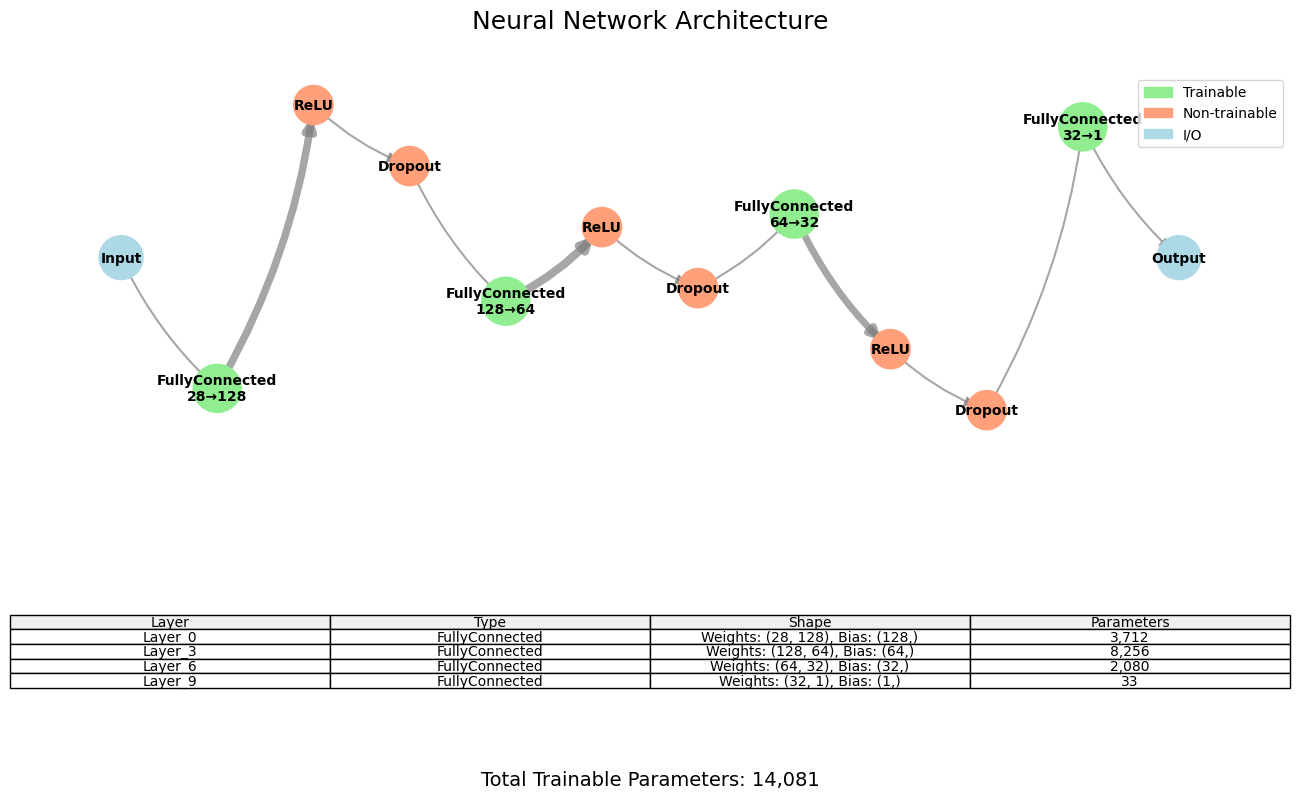

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |  1270.972634 |     762.829868 |   735.074474 | 0.00s
        50 |   672.701570 |     625.631549 |   684.674464 | 0.07s
       100 |   805.413496 |     597.343441 |   580.034736 | 0.12s
       150 |   509.333662 |     568.030012 |   567.608452 | 0.16s
       200 |   545.935093 |     507.894731 |   543.359318 | 0.22s
       250 |   608.724722 |     506.403417 |   504.837716 | 0.29s
       300 |   487.012485 |     508.877205 |   506.921389 | 0.36s
       350 |   725.222109 |     479.646371 |   479.711243 | 0.41s
       400 |   509.060472 |     473.381045 |   455.887034 | 0.47s
       450 |   400.400681 |     462.449399 |   463.007600 | 0.56s
       500 |   540.791434 | 

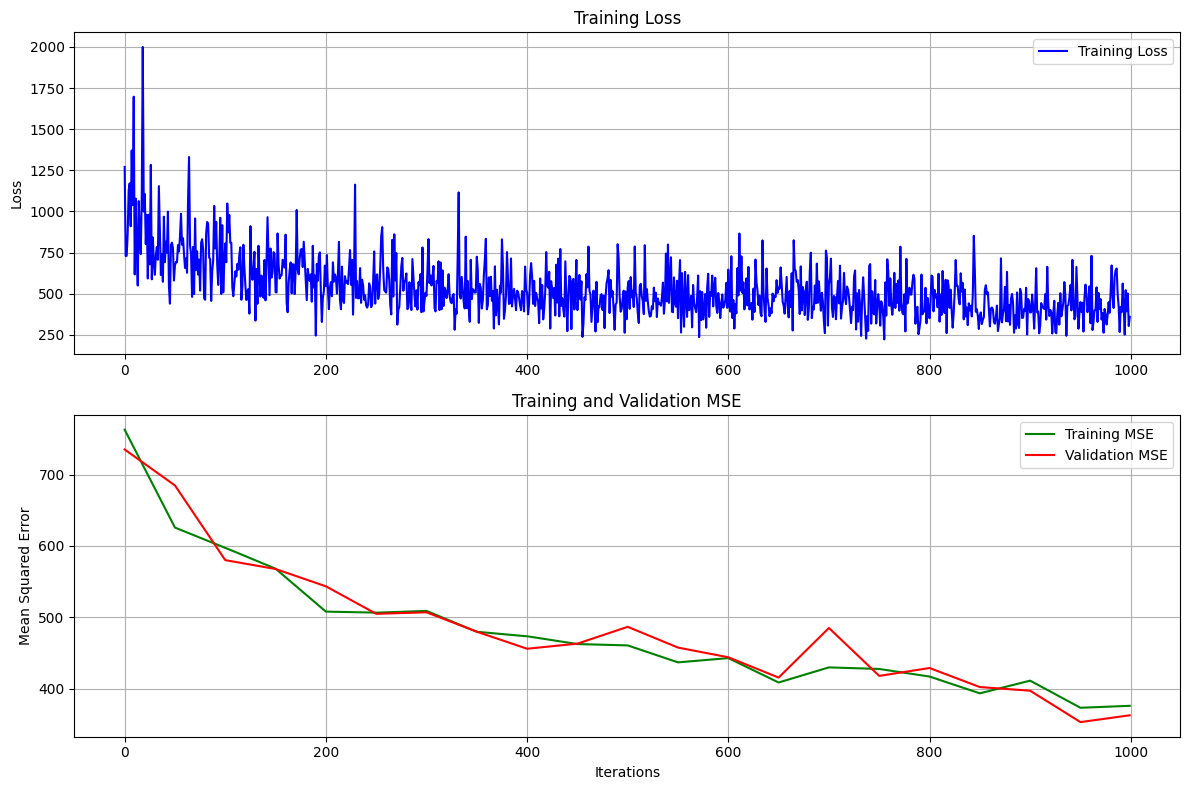

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 386.5646
RMSE: 19.6612
MAE: 15.7516
R²: -0.9281
Variance expliquée: 0.2070
📊 Génération des visualisations...


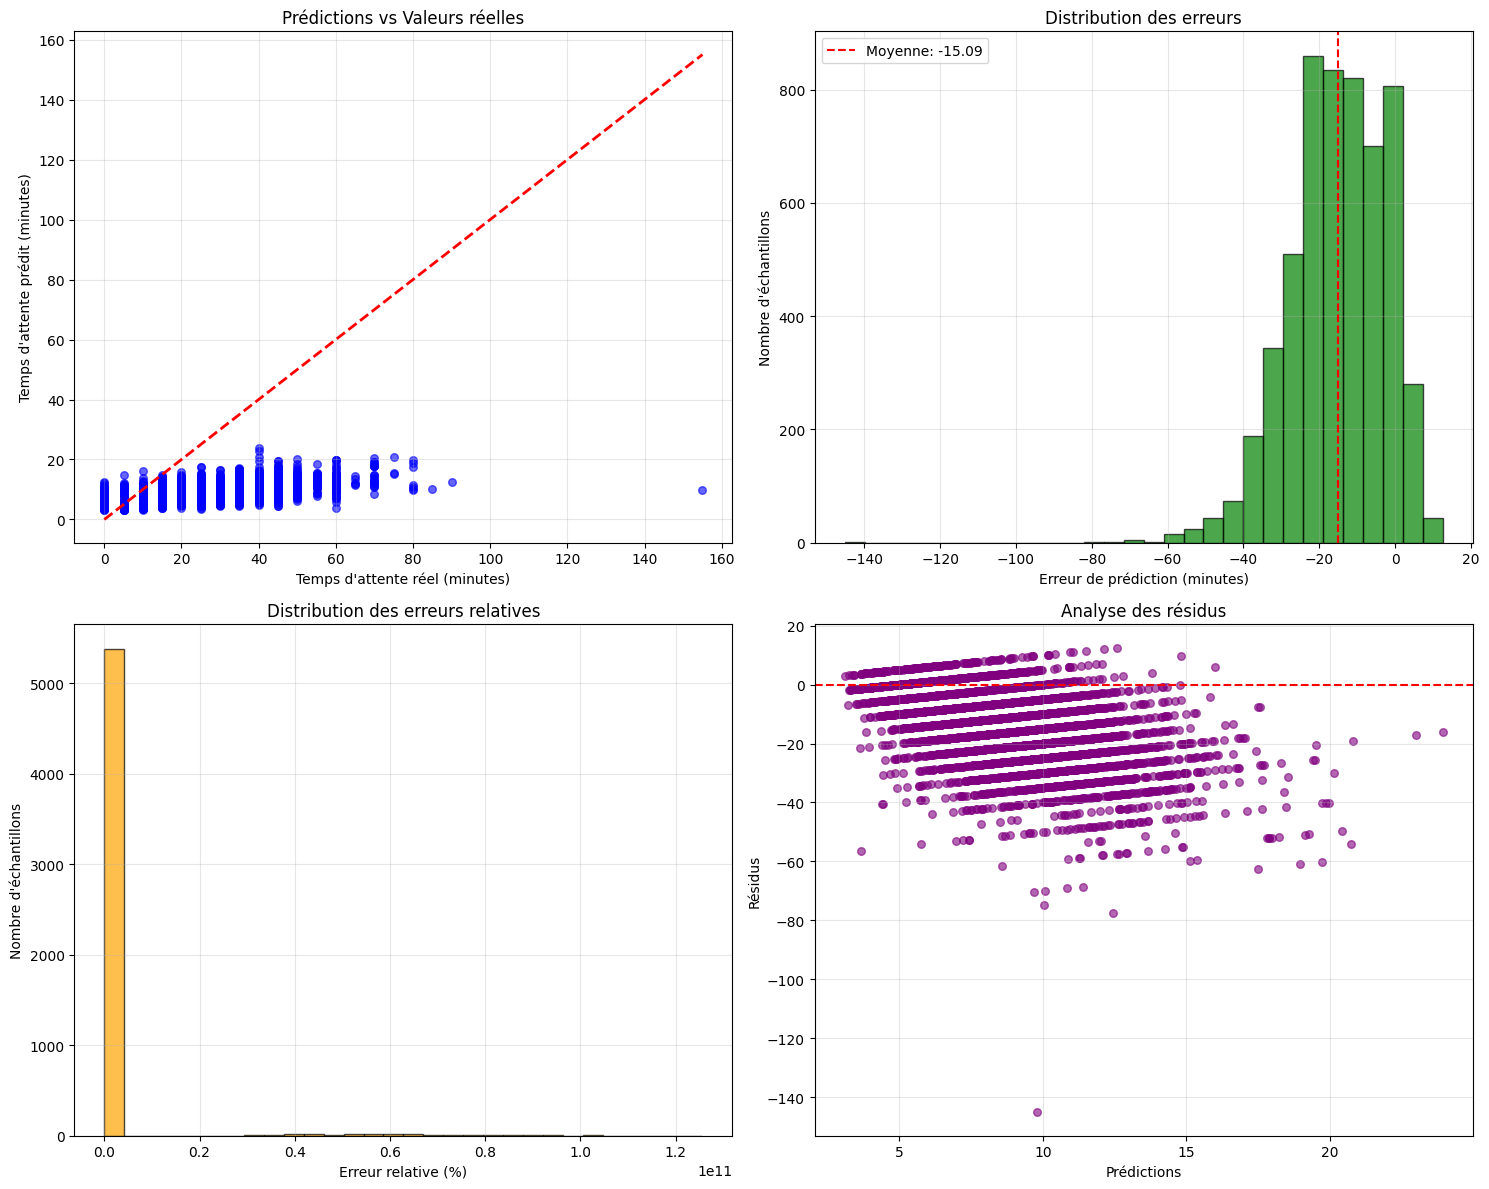

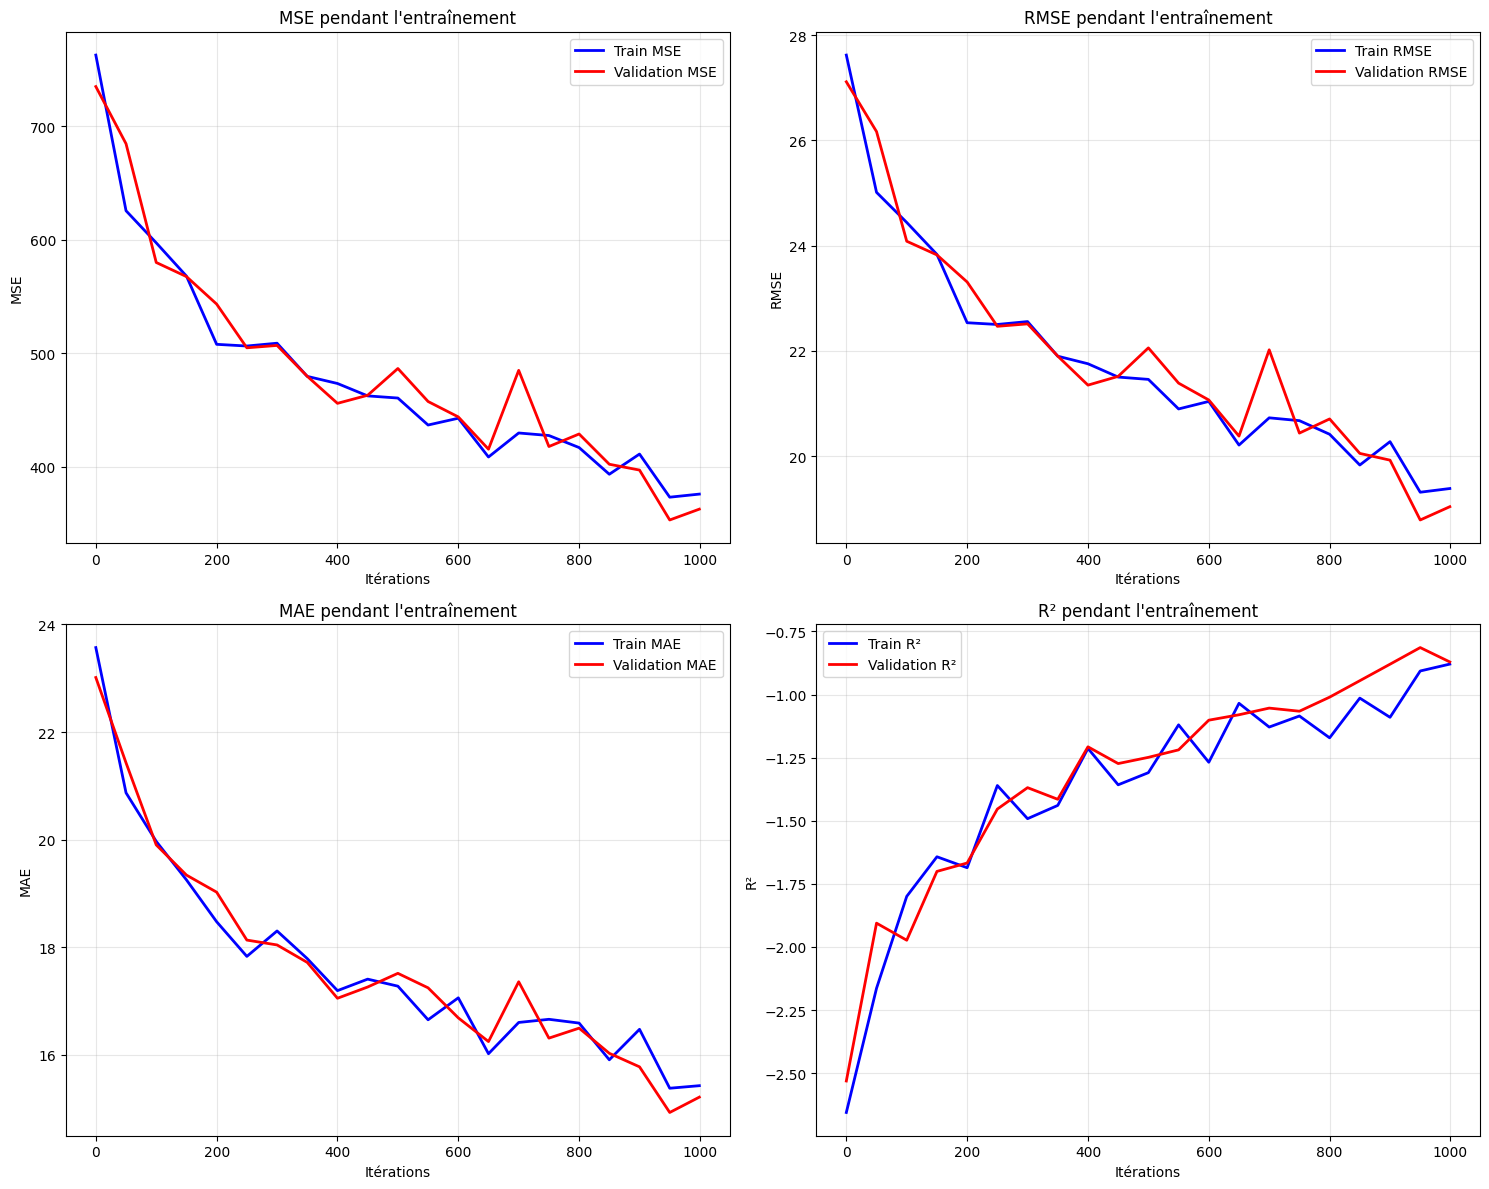


🚀 Analyse du modèle: Simple_Léger
🔧 Construction du modèle...


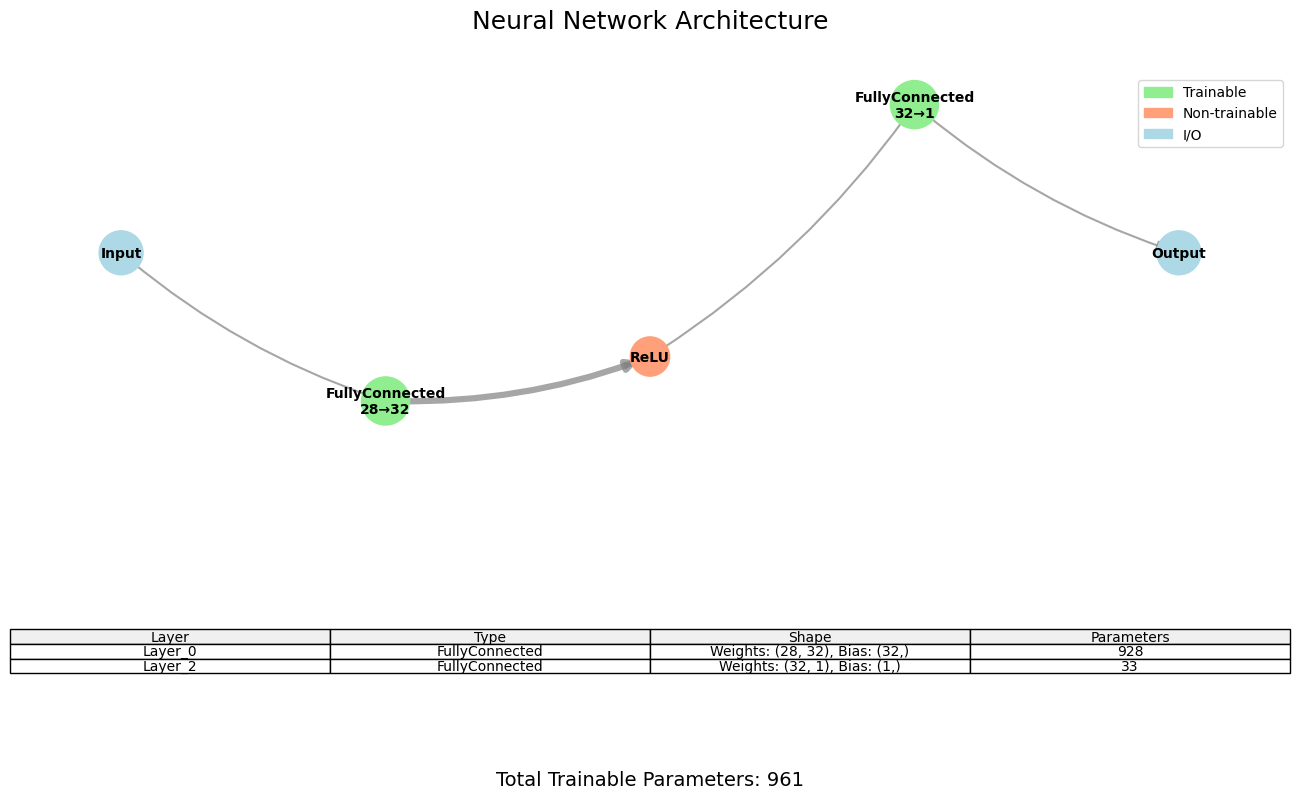

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   821.301336 |     731.724353 |   756.442151 | 0.00s
        50 |   139.972956 |     136.066425 |   141.384772 | 0.02s
       100 |   102.443728 |     110.183489 |   111.747749 | 0.05s
       150 |   186.053737 |     112.514070 |   120.485108 | 0.07s
       200 |    60.678495 |     106.050320 |   118.168673 | 0.09s
       250 |    97.774532 |      96.561967 |   111.040716 | 0.10s
       300 |    76.783700 |     105.166112 |   104.451988 | 0.11s
       350 |    78.275605 |      94.043345 |   110.784204 | 0.13s
       400 |   182.495651 |      94.294784 |   108.555641 | 0.14s
       450 |   153.170534 |      97.946003 |    99.873784 | 0.15s
       500 |    83.993334 | 

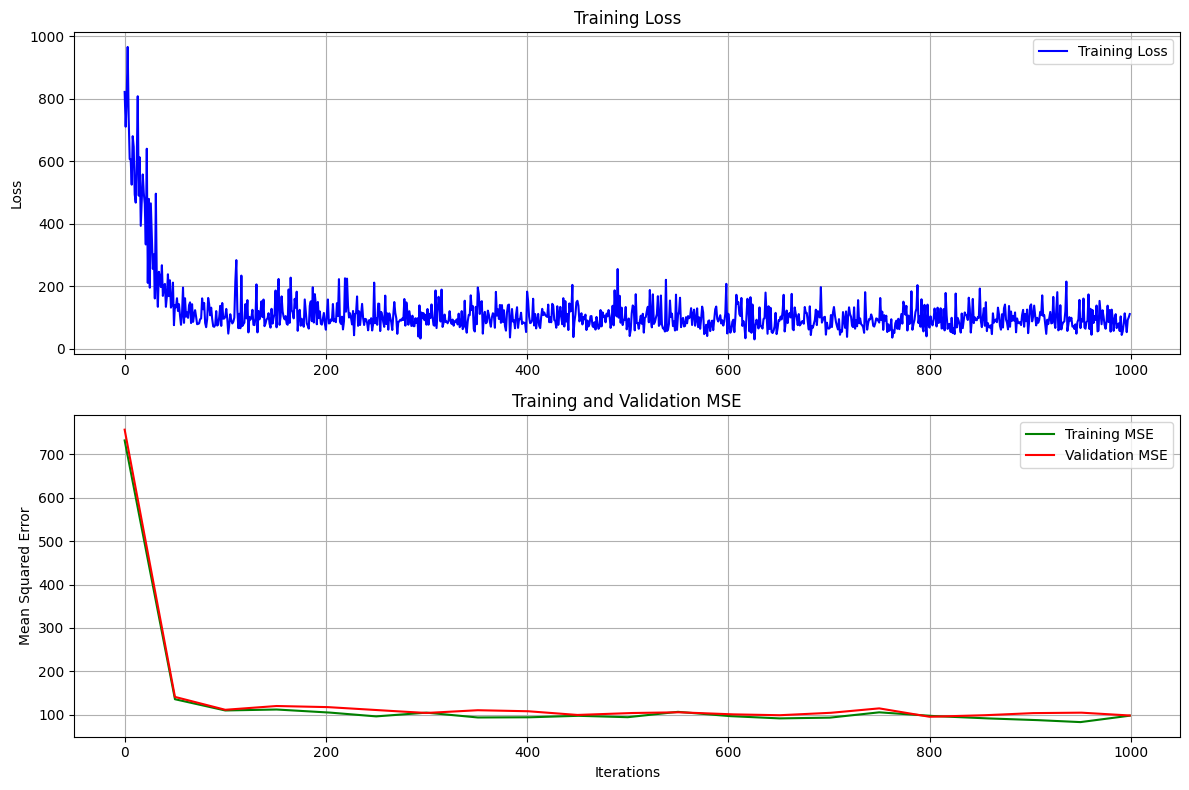

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 96.5215
RMSE: 9.8245
MAE: 7.2539
R²: 0.5186
Variance expliquée: 0.5331
📊 Génération des visualisations...


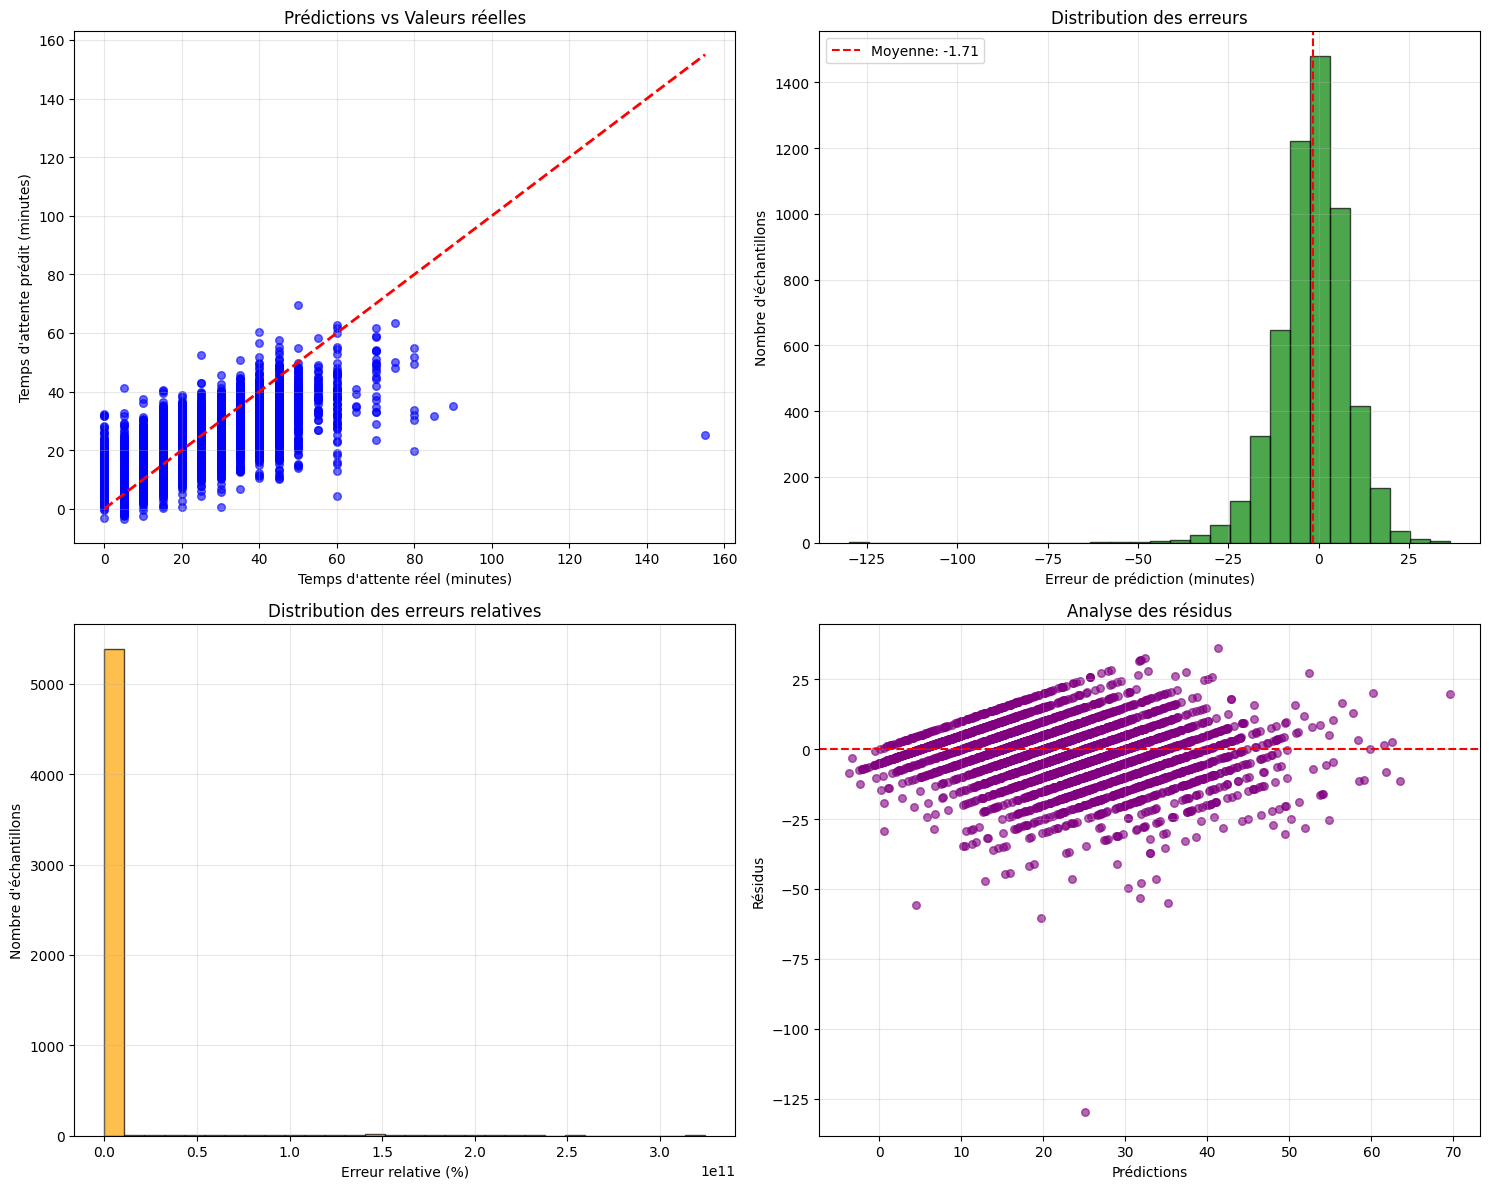

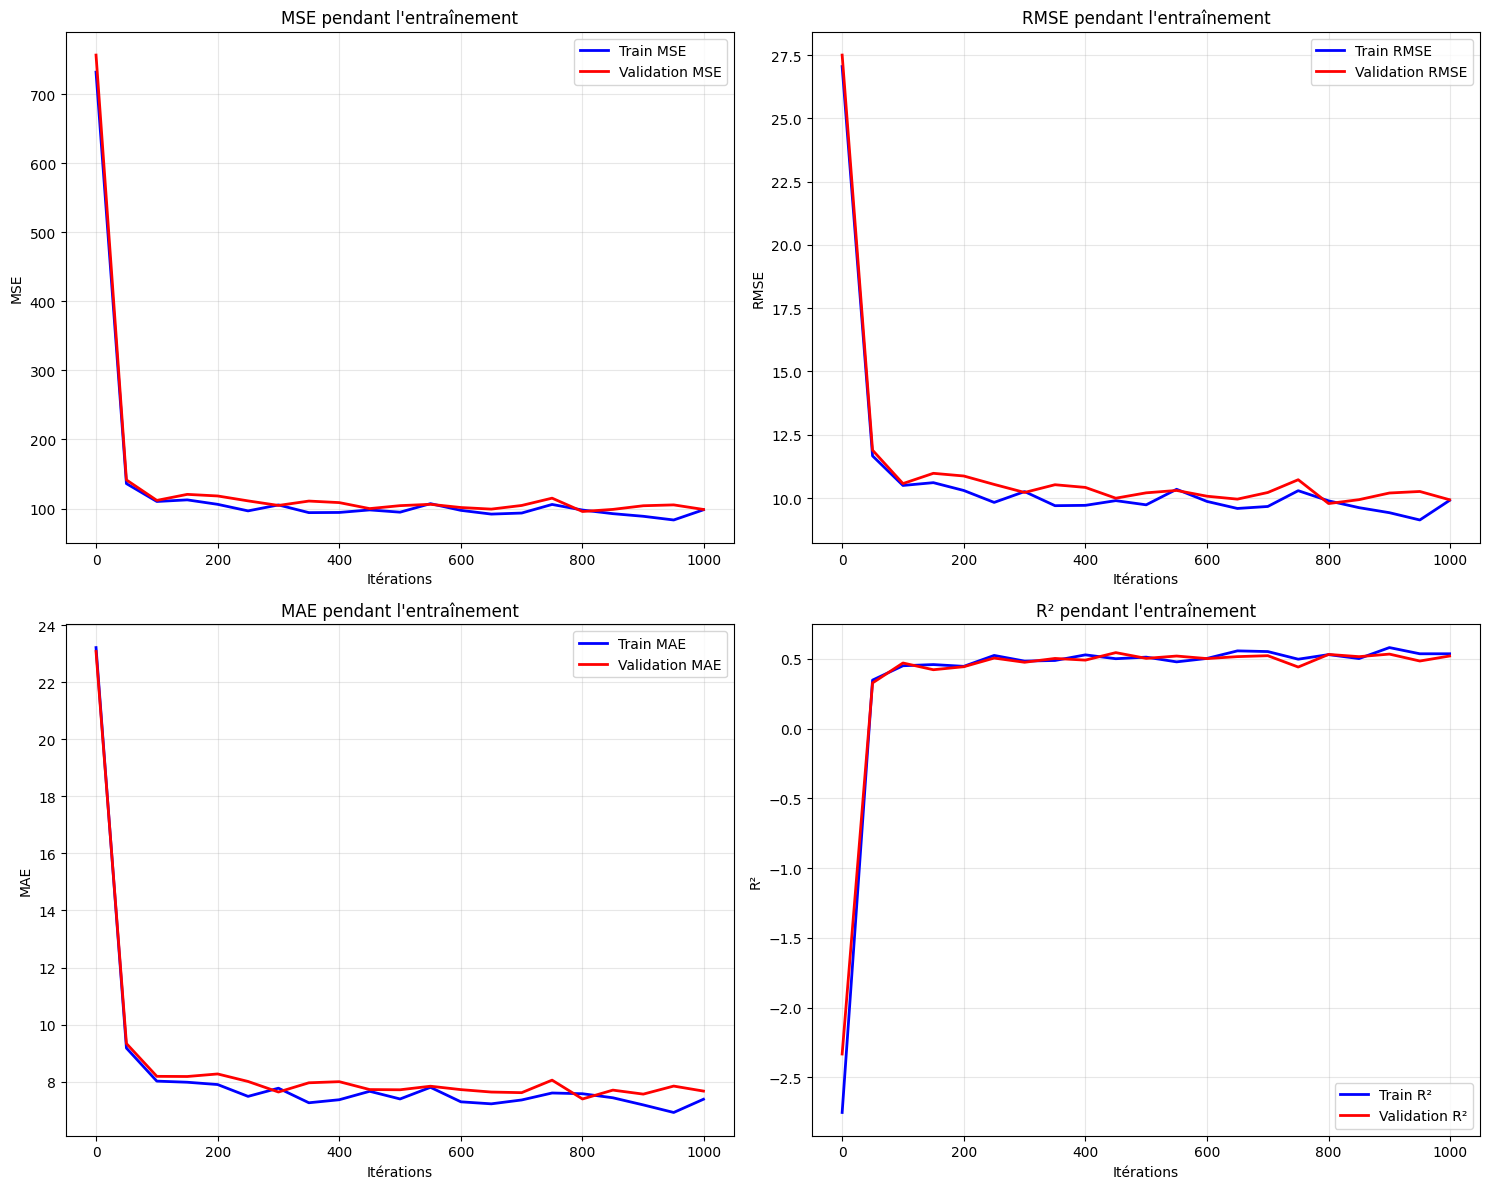


🚀 Analyse du modèle: Profond_Large
🔧 Construction du modèle...


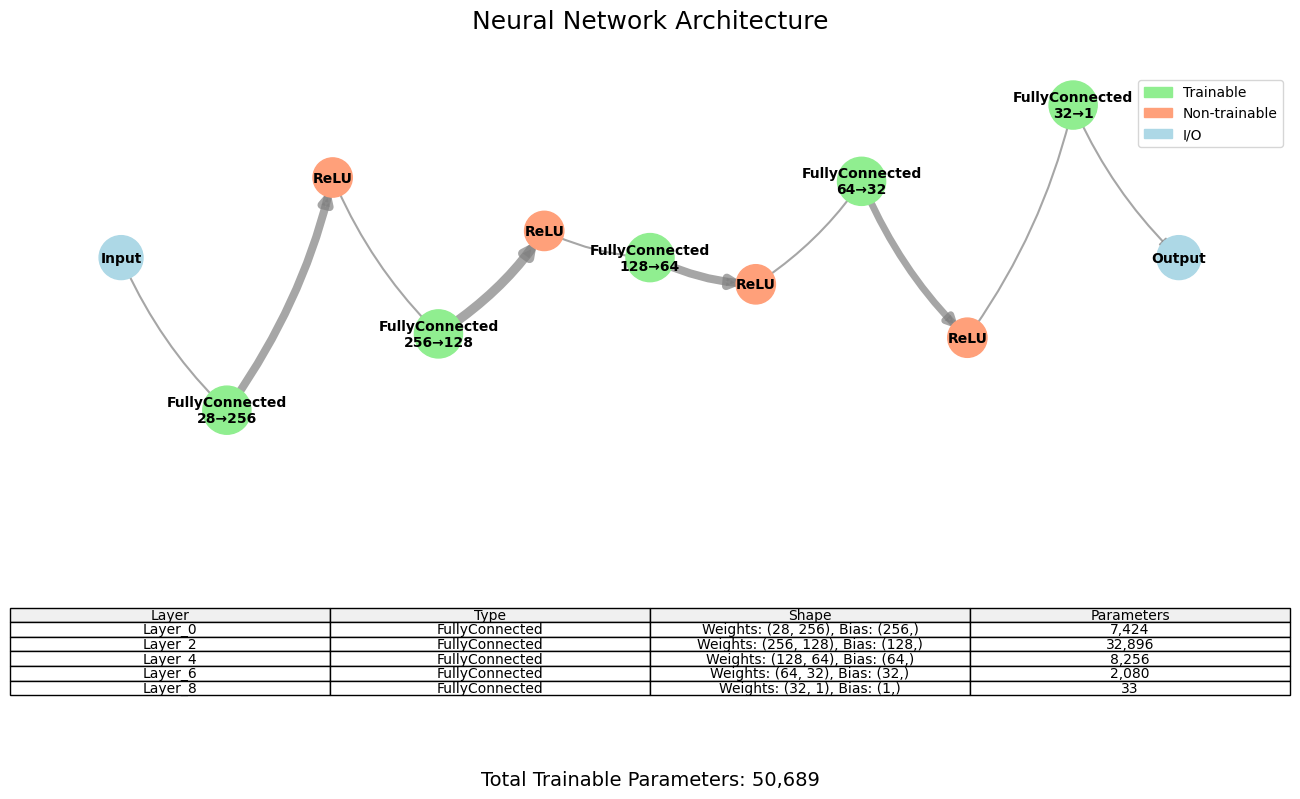

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   638.136432 |     766.395575 |   749.879391 | 0.01s
        50 |   130.322291 |     157.812293 |   174.851861 | 0.16s
       100 |    96.718903 |     117.820770 |   114.687364 | 0.29s
       150 |   165.583072 |     113.086196 |   115.833285 | 0.41s
       200 |    90.164373 |     104.652748 |   115.447951 | 0.56s
       250 |   127.082023 |     107.223079 |   102.762946 | 0.73s
       300 |    96.502231 |      97.774990 |   104.312755 | 0.89s
       350 |   212.116014 |     107.604187 |   102.192382 | 1.01s
       400 |   200.571815 |      87.863678 |   101.185610 | 1.16s
       450 |   112.779523 |      81.039598 |    99.072393 | 1.30s
       500 |   100.429068 | 

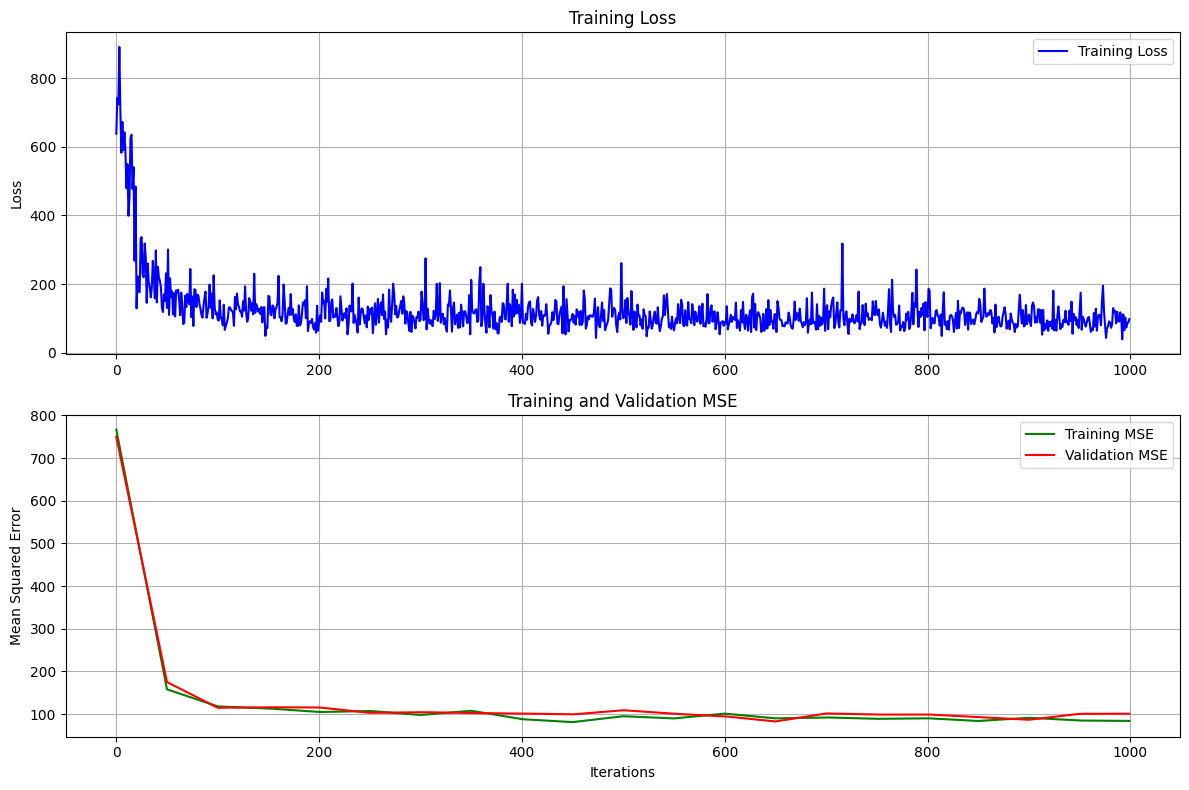

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 95.1664
RMSE: 9.7553
MAE: 7.0860
R²: 0.5253
Variance expliquée: 0.5391
📊 Génération des visualisations...


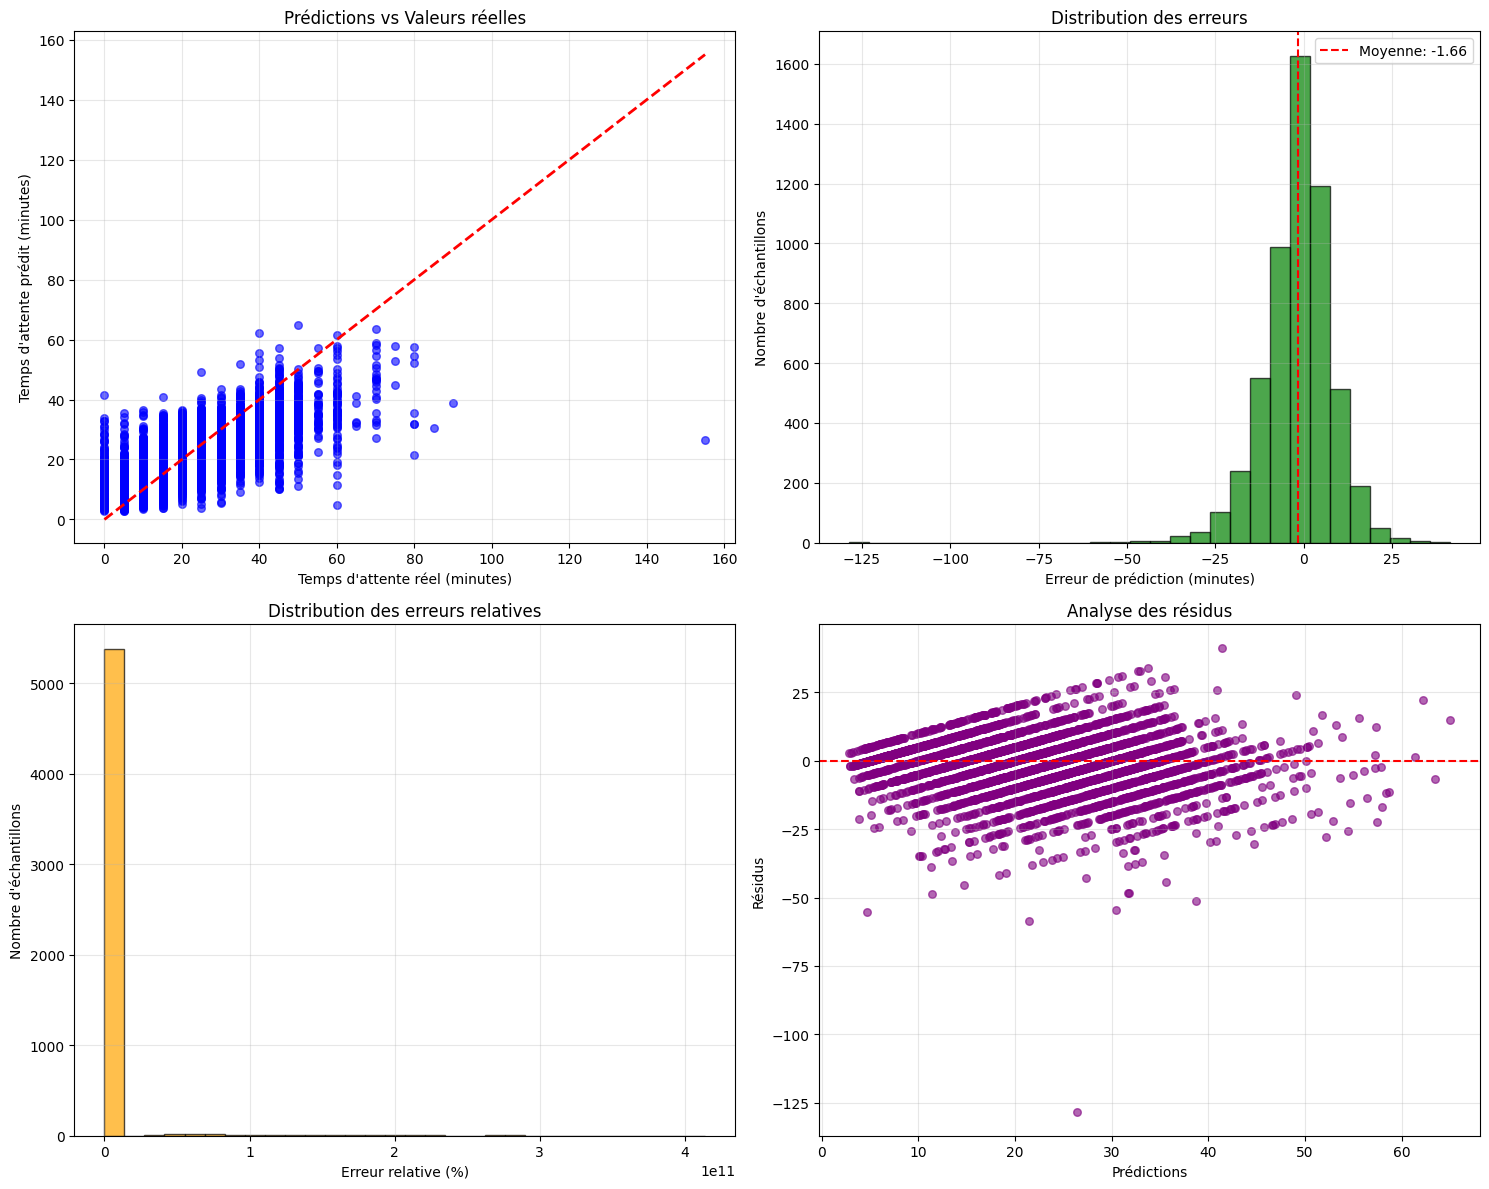

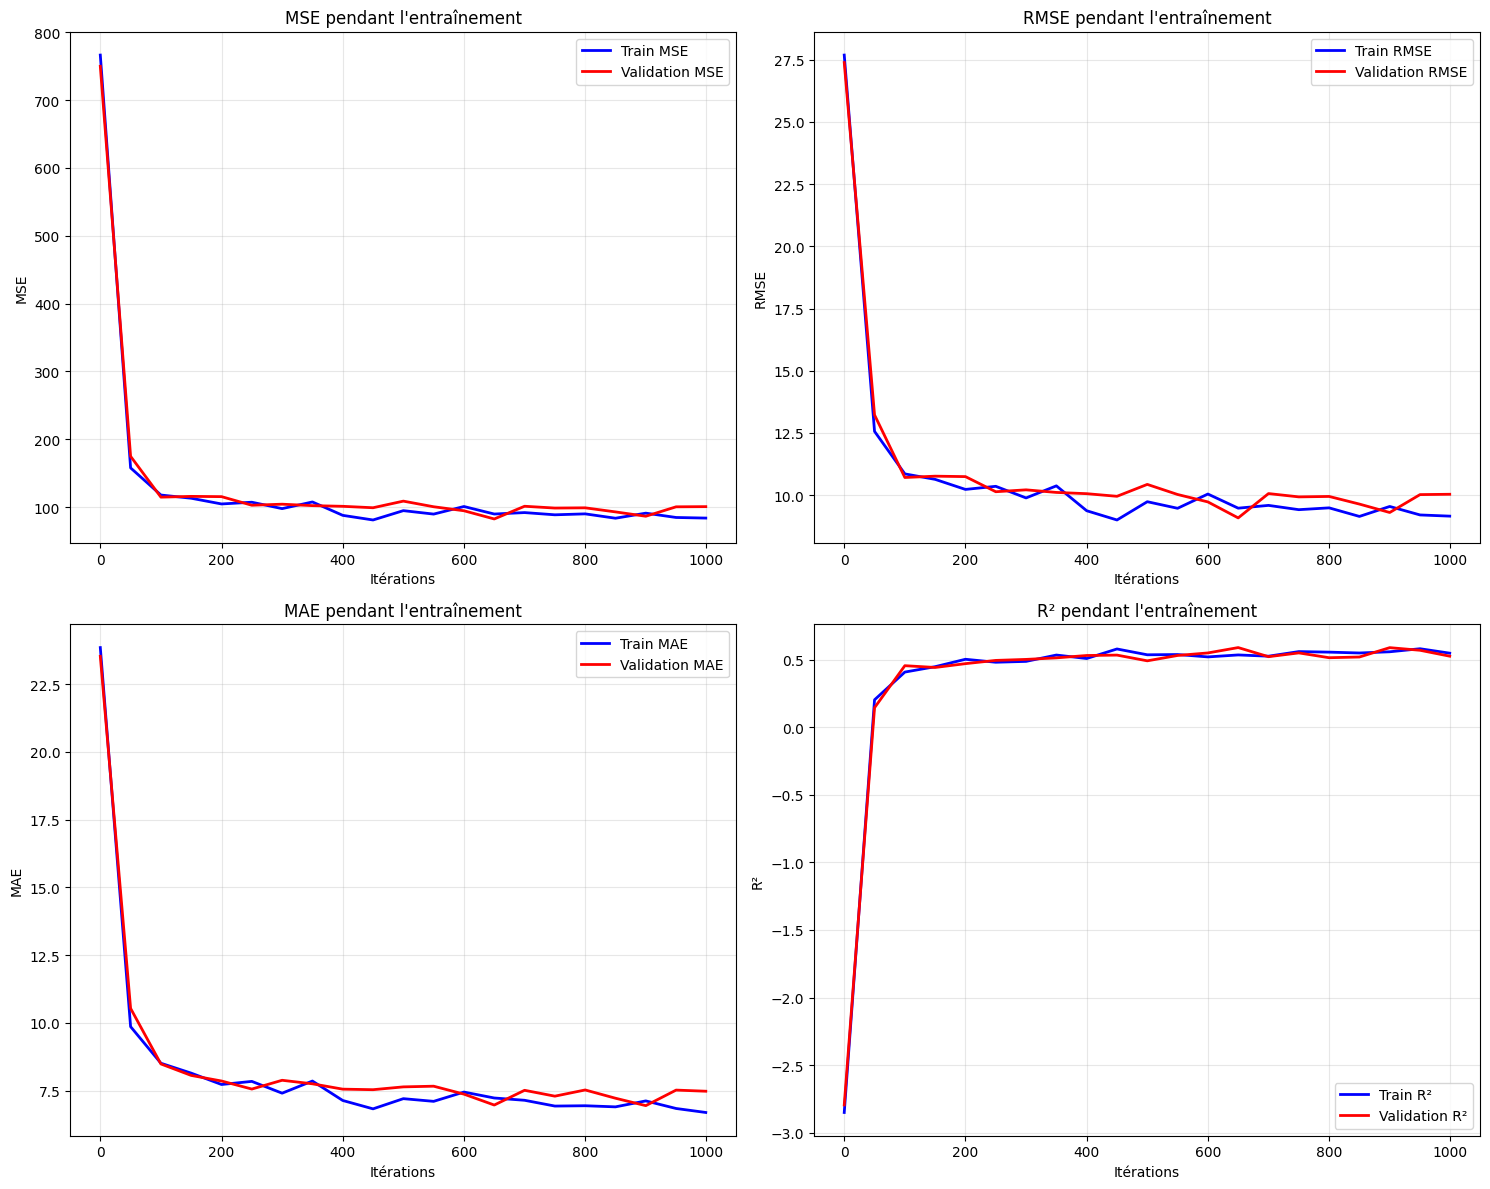


🚀 Analyse du modèle: Dropout_Robuste
🔧 Construction du modèle...


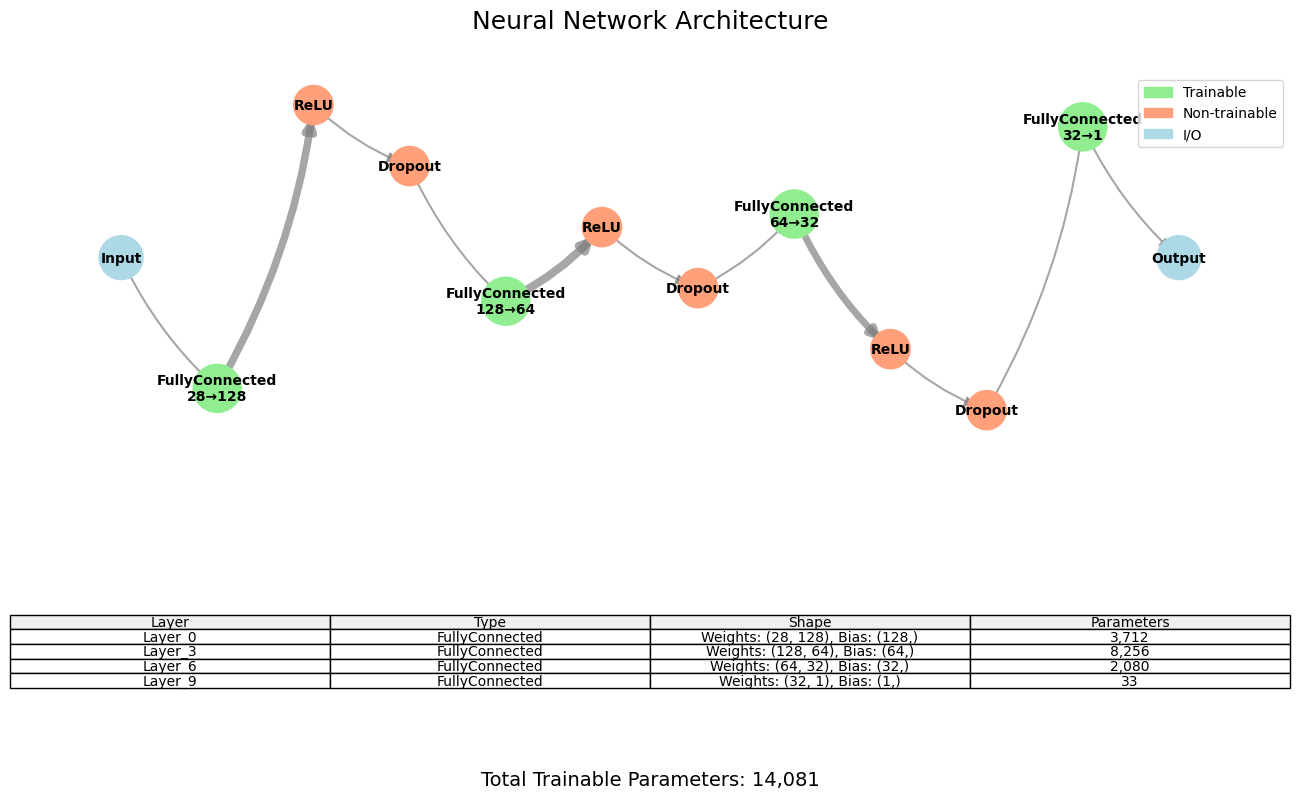

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   677.046195 |     844.567454 |   798.212513 | 0.00s
        50 |  1209.609922 |     690.226174 |   670.825176 | 0.06s
       100 |  1070.060386 |     628.259942 |   628.986340 | 0.10s
       150 |   683.290596 |     600.947481 |   538.518134 | 0.14s
       200 |   702.076025 |     569.001228 |   540.293735 | 0.19s
       250 |   524.630852 |     493.674646 |   515.737581 | 0.24s
       300 |   741.336103 |     488.978318 |   488.147154 | 0.29s
       350 |   509.061227 |     468.623612 |   479.703720 | 0.33s
       400 |   528.665797 |     430.415159 |   445.950593 | 0.38s
       450 |   573.086523 |     462.761417 |   525.468548 | 0.42s
       500 |   525.205401 | 

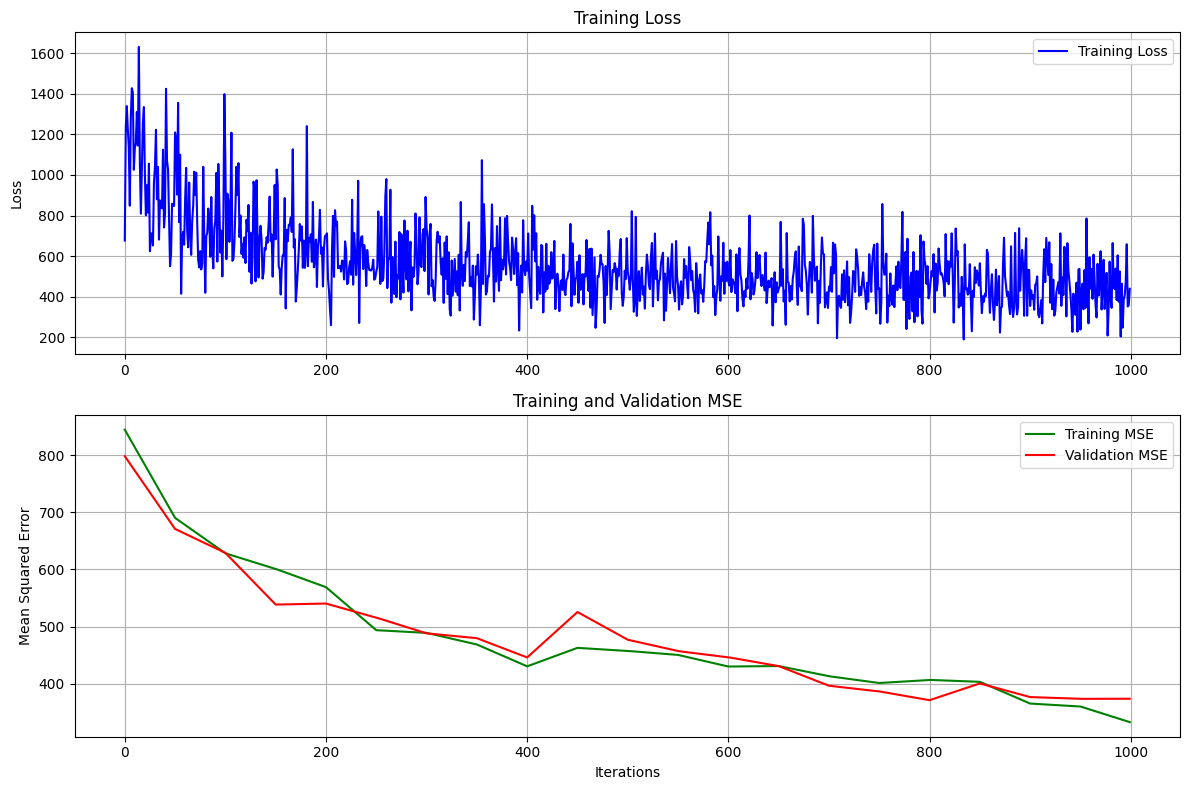

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 352.0299
RMSE: 18.7625
MAE: 14.9025
R²: -0.7559
Variance expliquée: 0.2372
📊 Génération des visualisations...


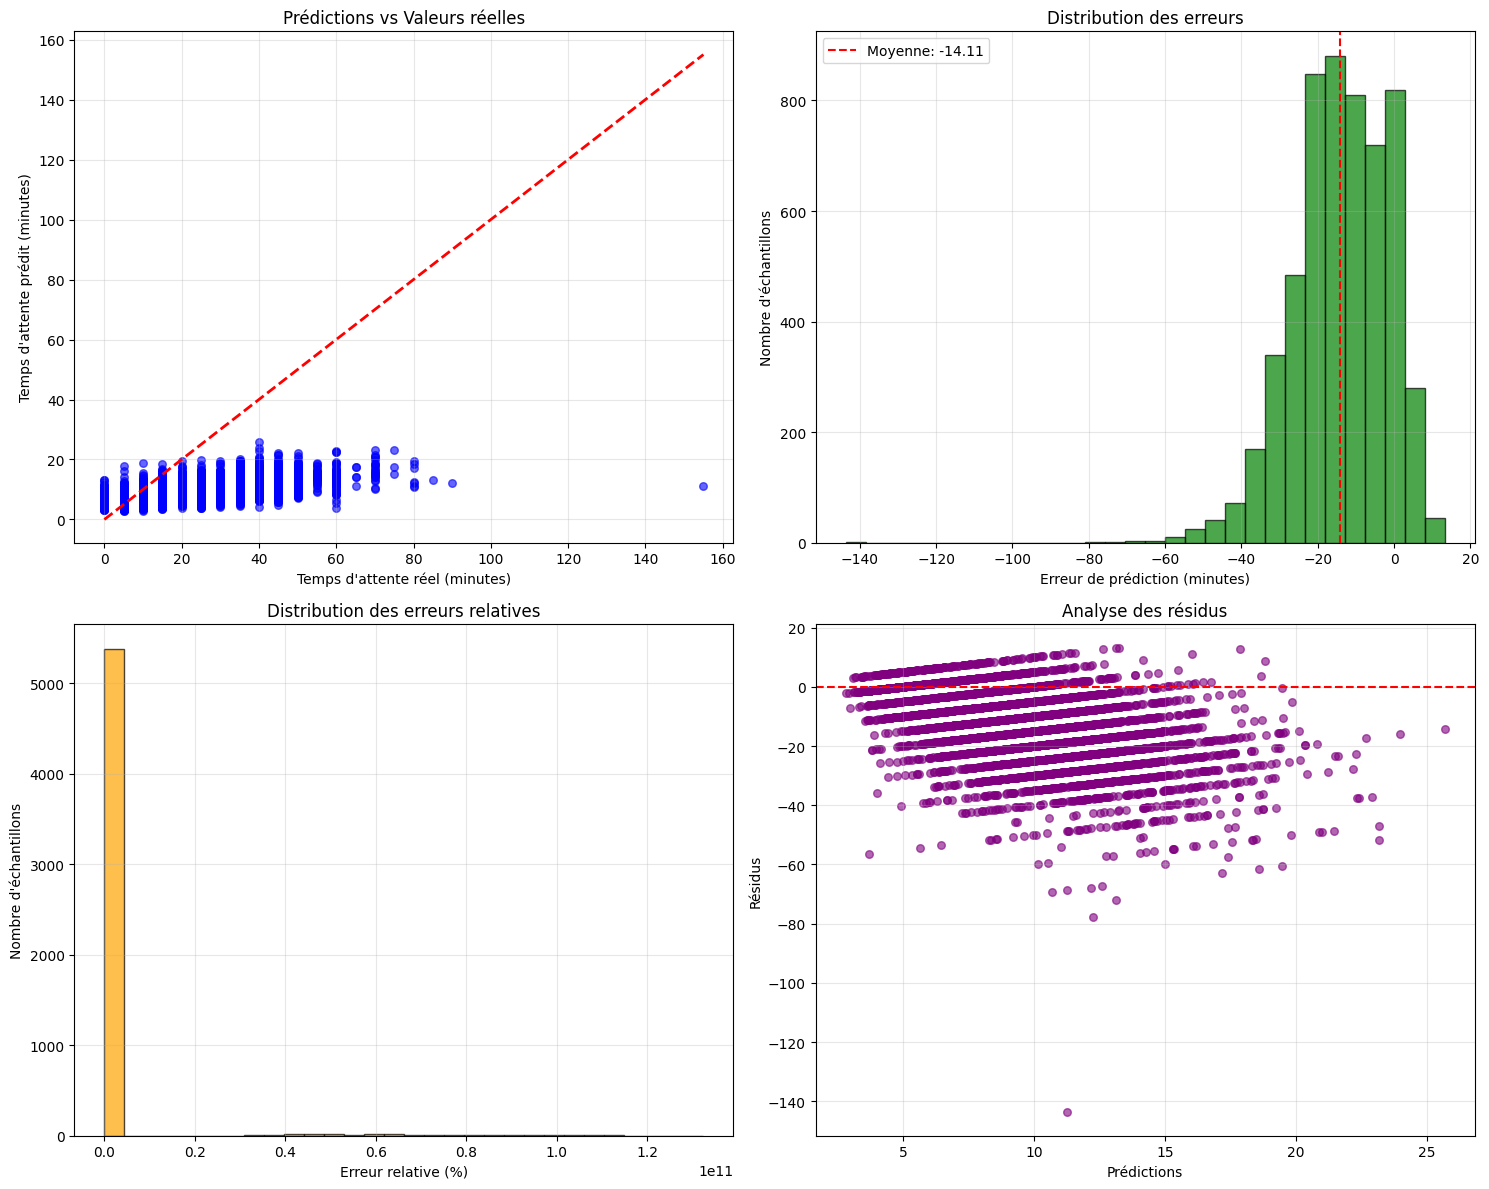

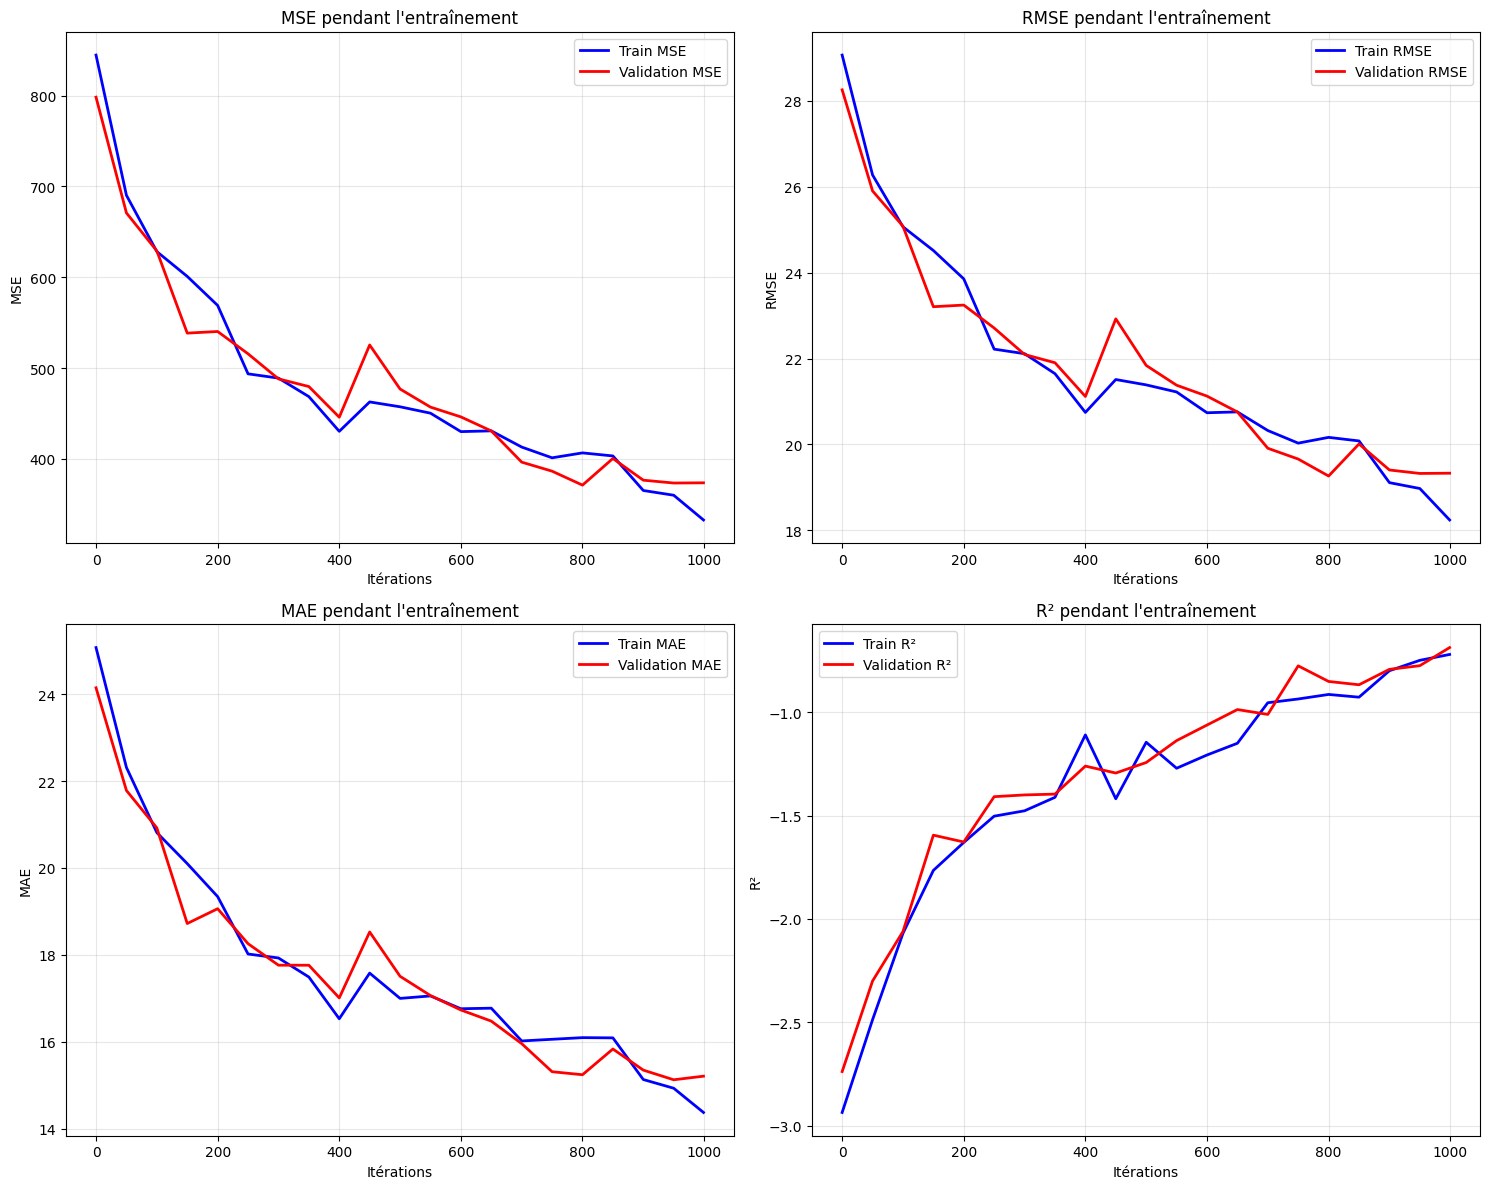


🚀 Analyse du modèle: Tanh_Centré
🔧 Construction du modèle...


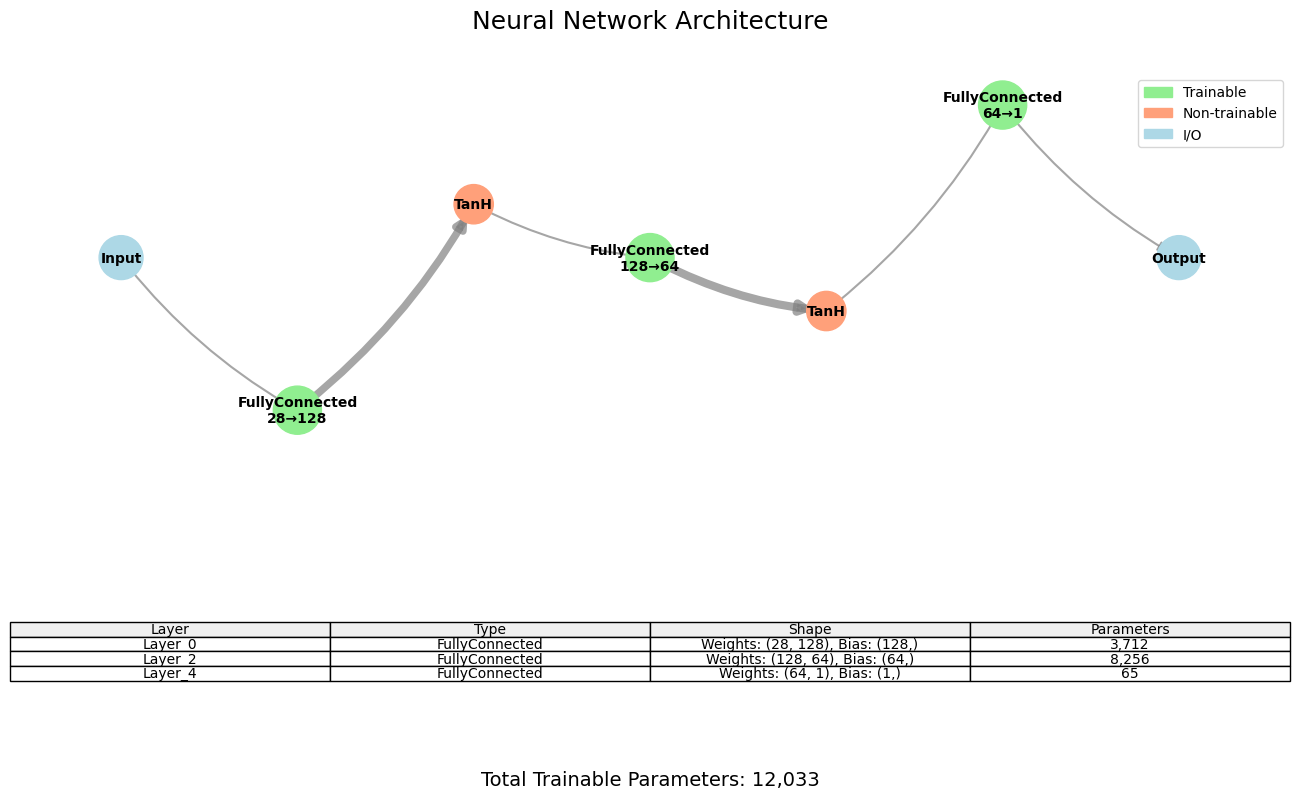

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   760.490467 |     767.286584 |   736.910937 | 0.00s
        50 |   328.222106 |     444.010611 |   456.918776 | 0.13s
       100 |   445.718515 |     258.475879 |   268.979544 | 0.19s
       150 |   334.553118 |     218.448348 |   228.267047 | 0.22s
       200 |   107.700569 |     186.578258 |   210.261947 | 0.27s
       250 |   124.167891 |     196.570831 |   175.149372 | 0.30s
       300 |   269.465561 |     153.534210 |   151.720151 | 0.34s
       350 |   126.730412 |     146.514549 |   153.014228 | 0.39s
       400 |   105.455544 |     133.587322 |   140.165206 | 0.42s
       450 |   124.476760 |     121.777520 |   136.389574 | 0.46s
       500 |   166.523251 | 

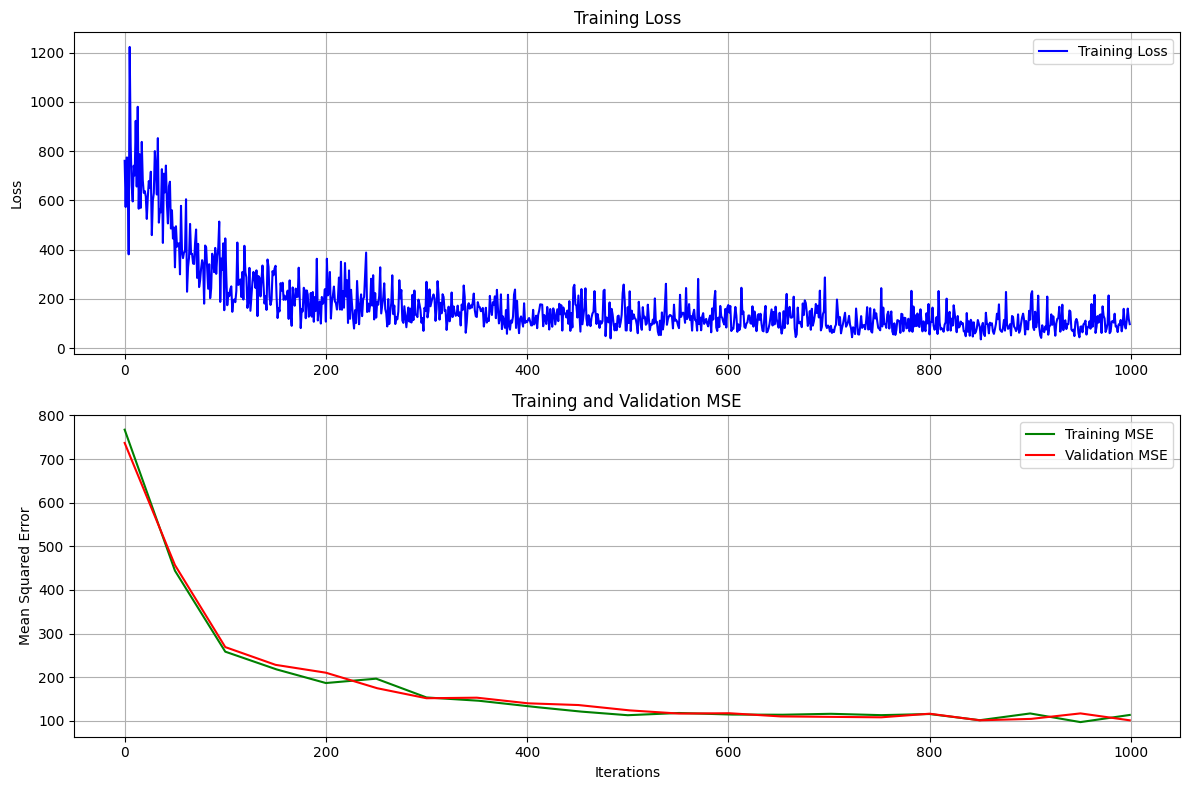

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 102.8364
RMSE: 10.1408
MAE: 7.4318
R²: 0.4871
Variance expliquée: 0.4893
📊 Génération des visualisations...


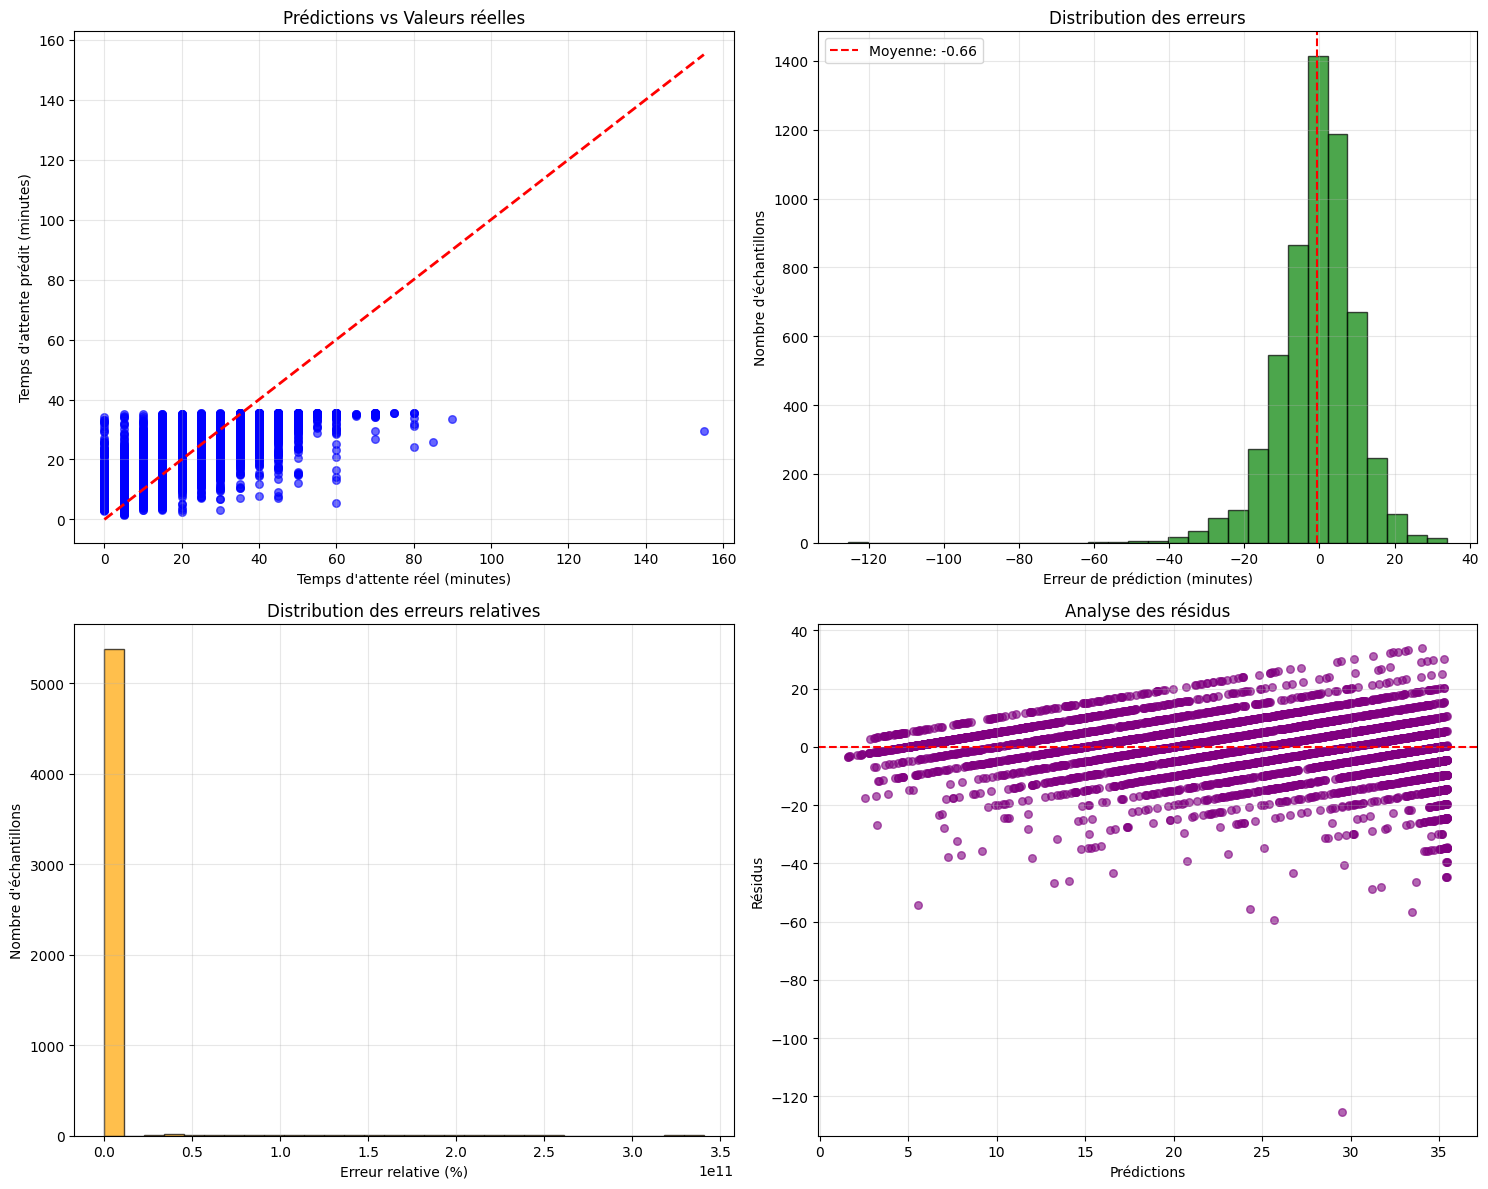

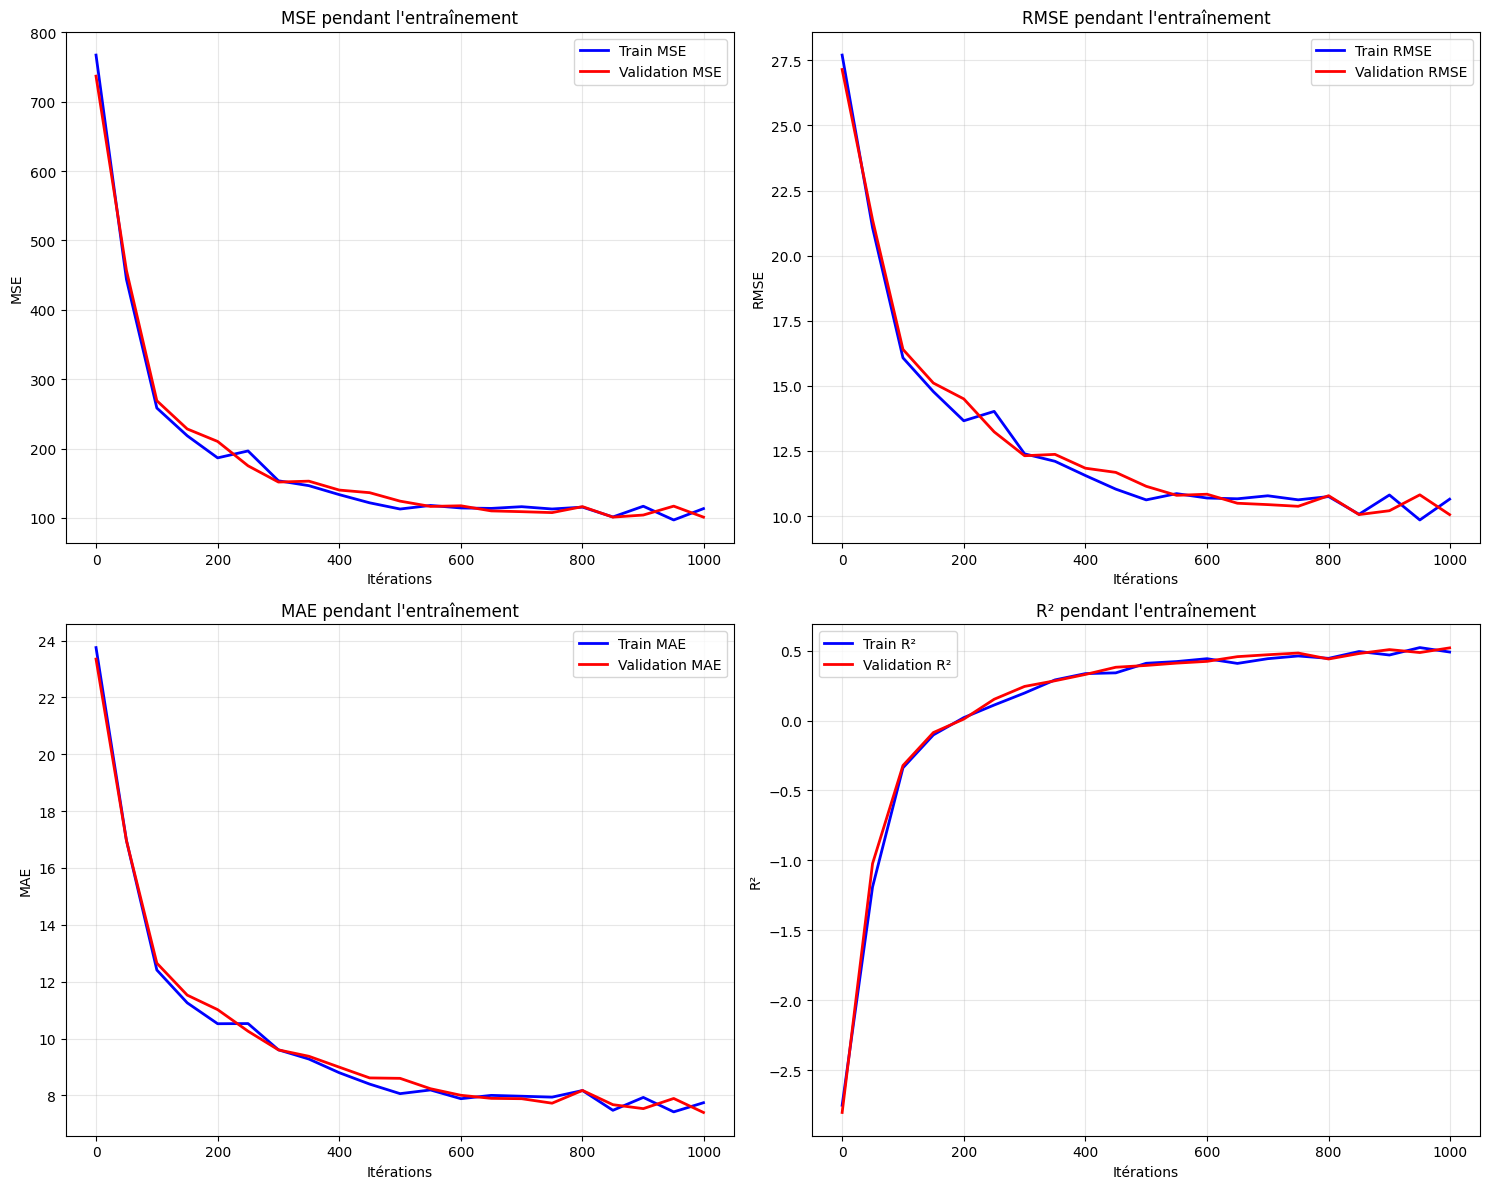


🚀 Analyse du modèle: Apprentissage_Rapide
🔧 Construction du modèle...


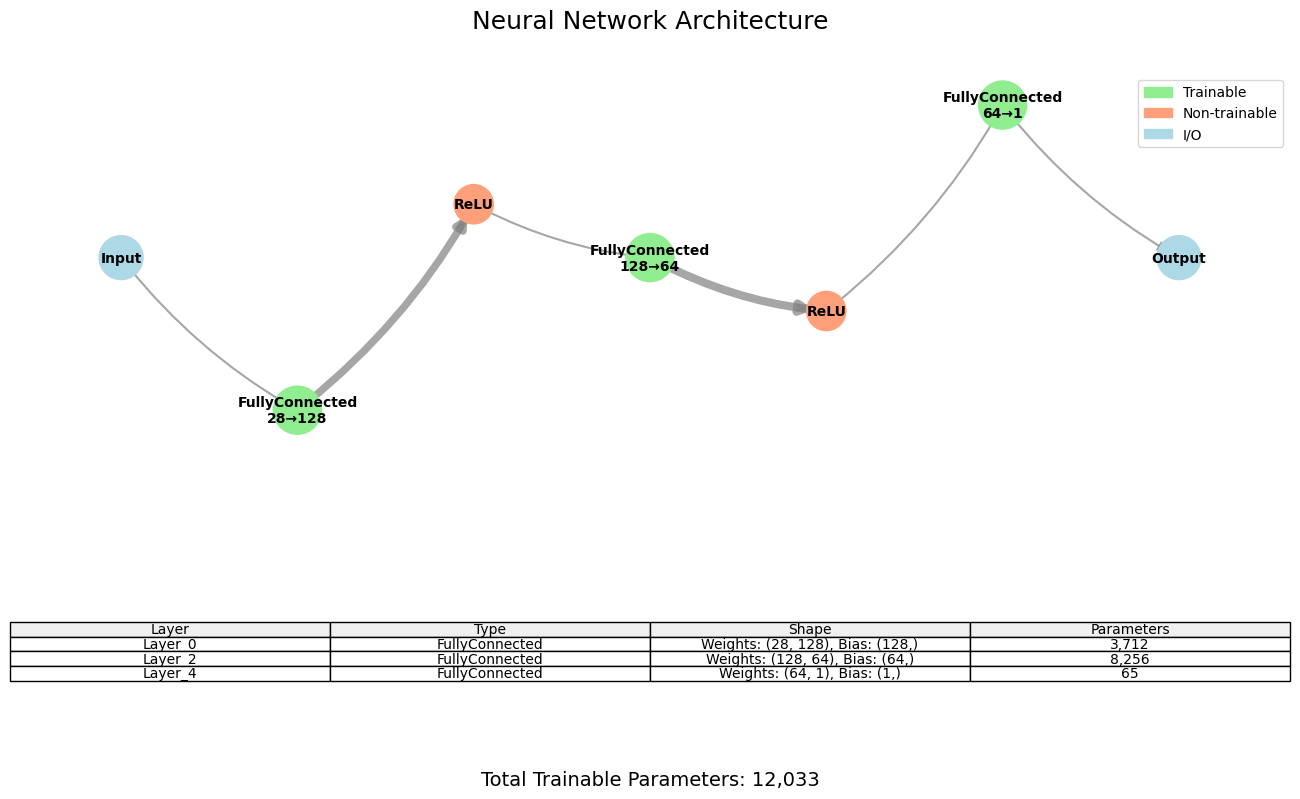

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   756.633953 |     608.459897 |   571.828973 | 0.00s
        50 |    65.137775 |     118.414220 |   121.102648 | 0.07s
       100 |    84.869847 |     108.996515 |   119.336855 | 0.10s
       150 |   110.941728 |     113.657058 |   121.888856 | 0.13s
       200 |    60.174718 |      93.838100 |   103.655257 | 0.17s
       250 |   138.681492 |      90.217630 |   116.133505 | 0.19s
       300 |   122.640478 |     104.531323 |   111.128631 | 0.22s
       350 |   197.543325 |      97.731149 |   102.461054 | 0.26s
       400 |   147.093961 |      91.549607 |    99.565880 | 0.30s
       450 |   118.415482 |     109.126528 |    91.636382 | 0.36s
       500 |   118.327898 | 

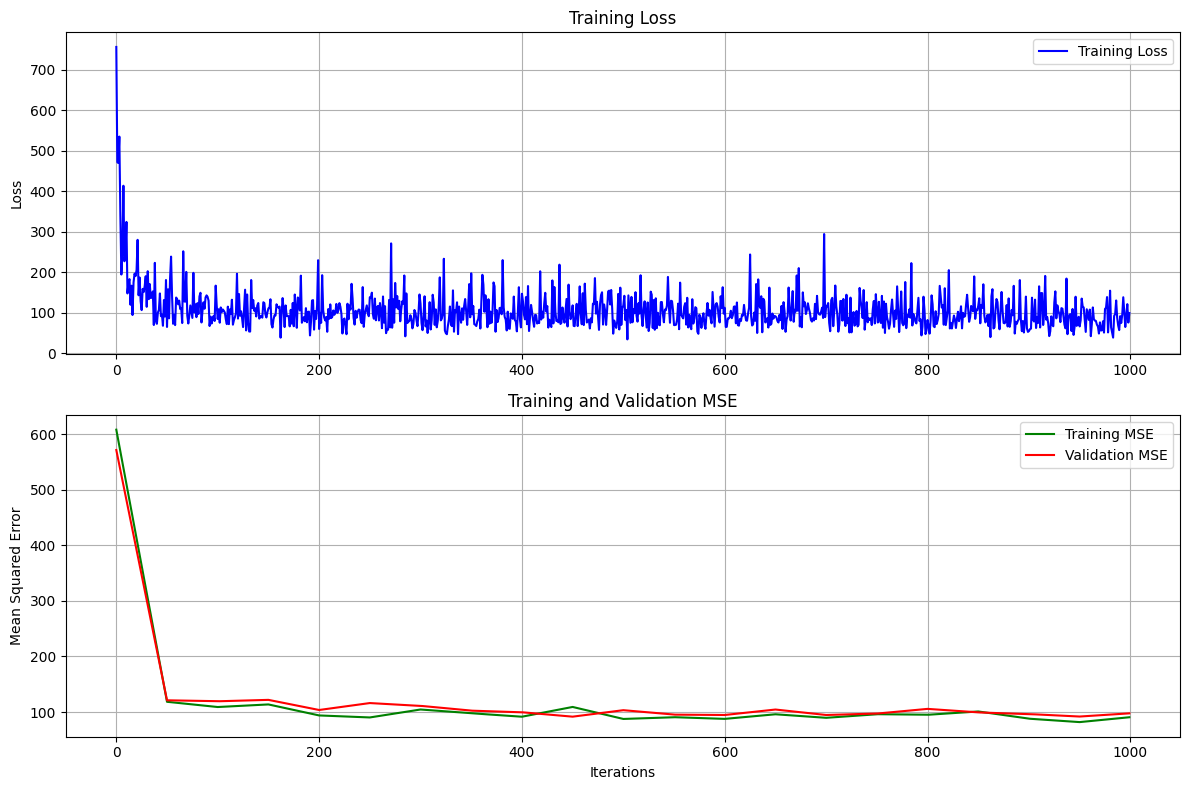

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 94.6206
RMSE: 9.7273
MAE: 7.1655
R²: 0.5280
Variance expliquée: 0.5412
📊 Génération des visualisations...


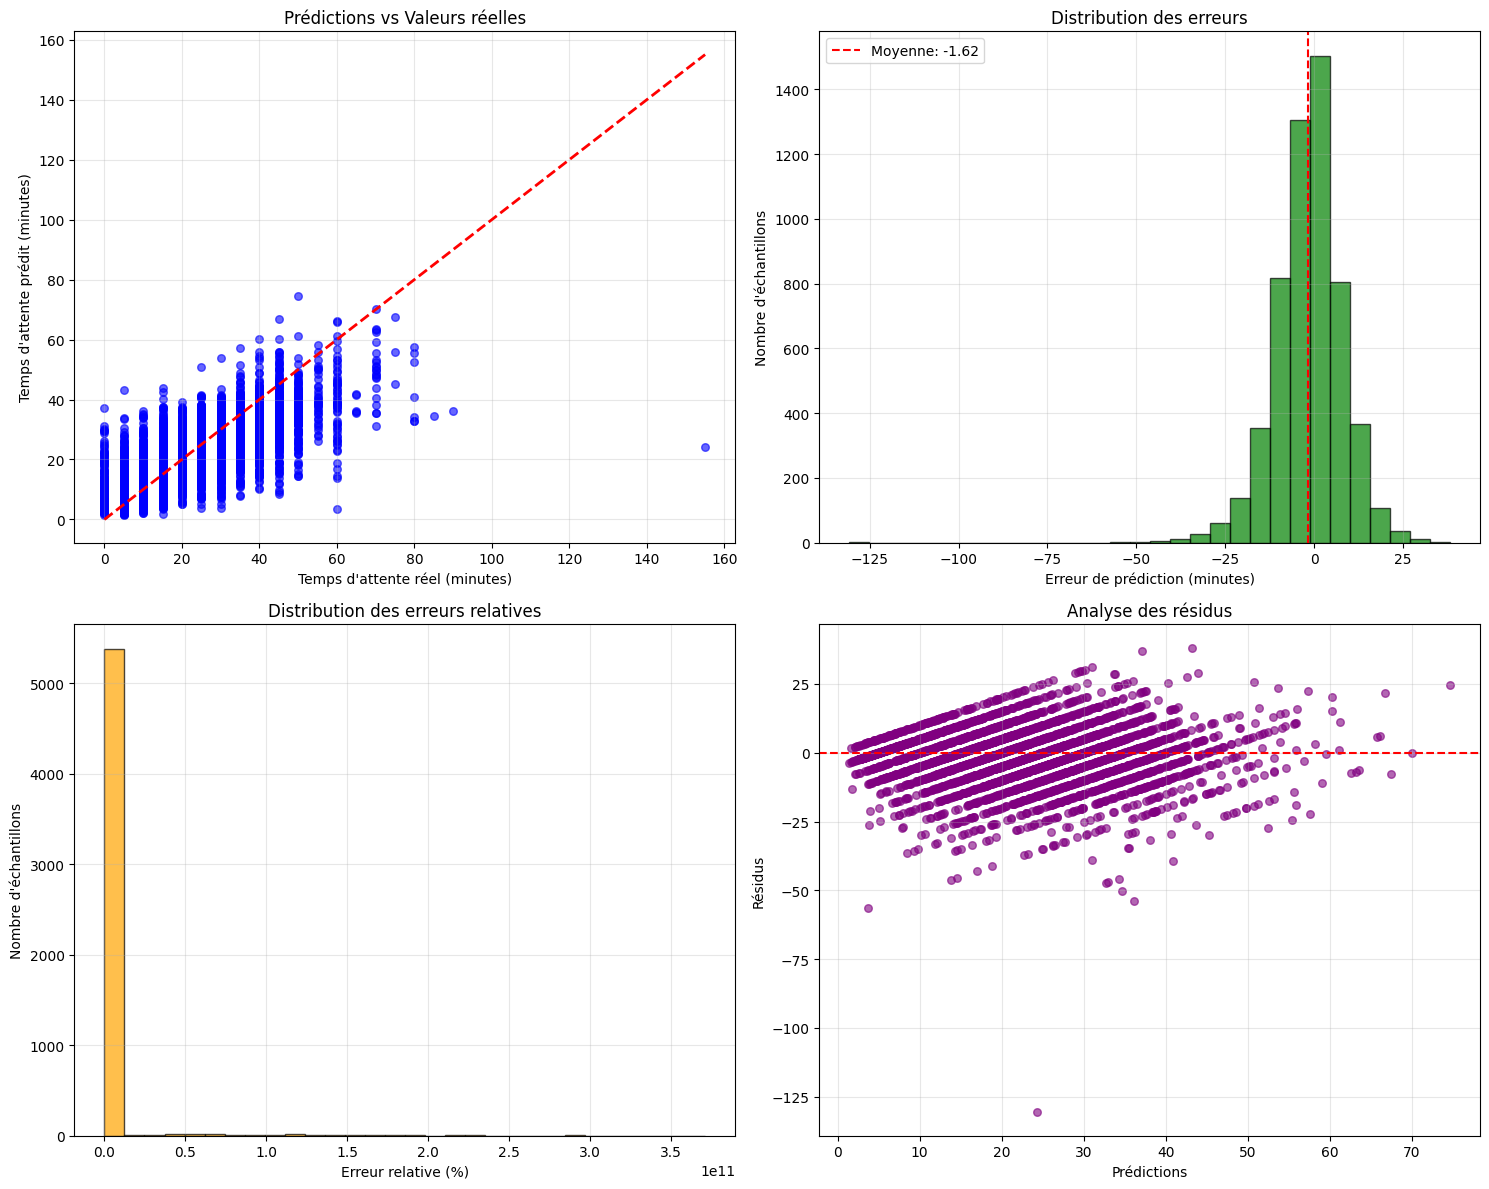

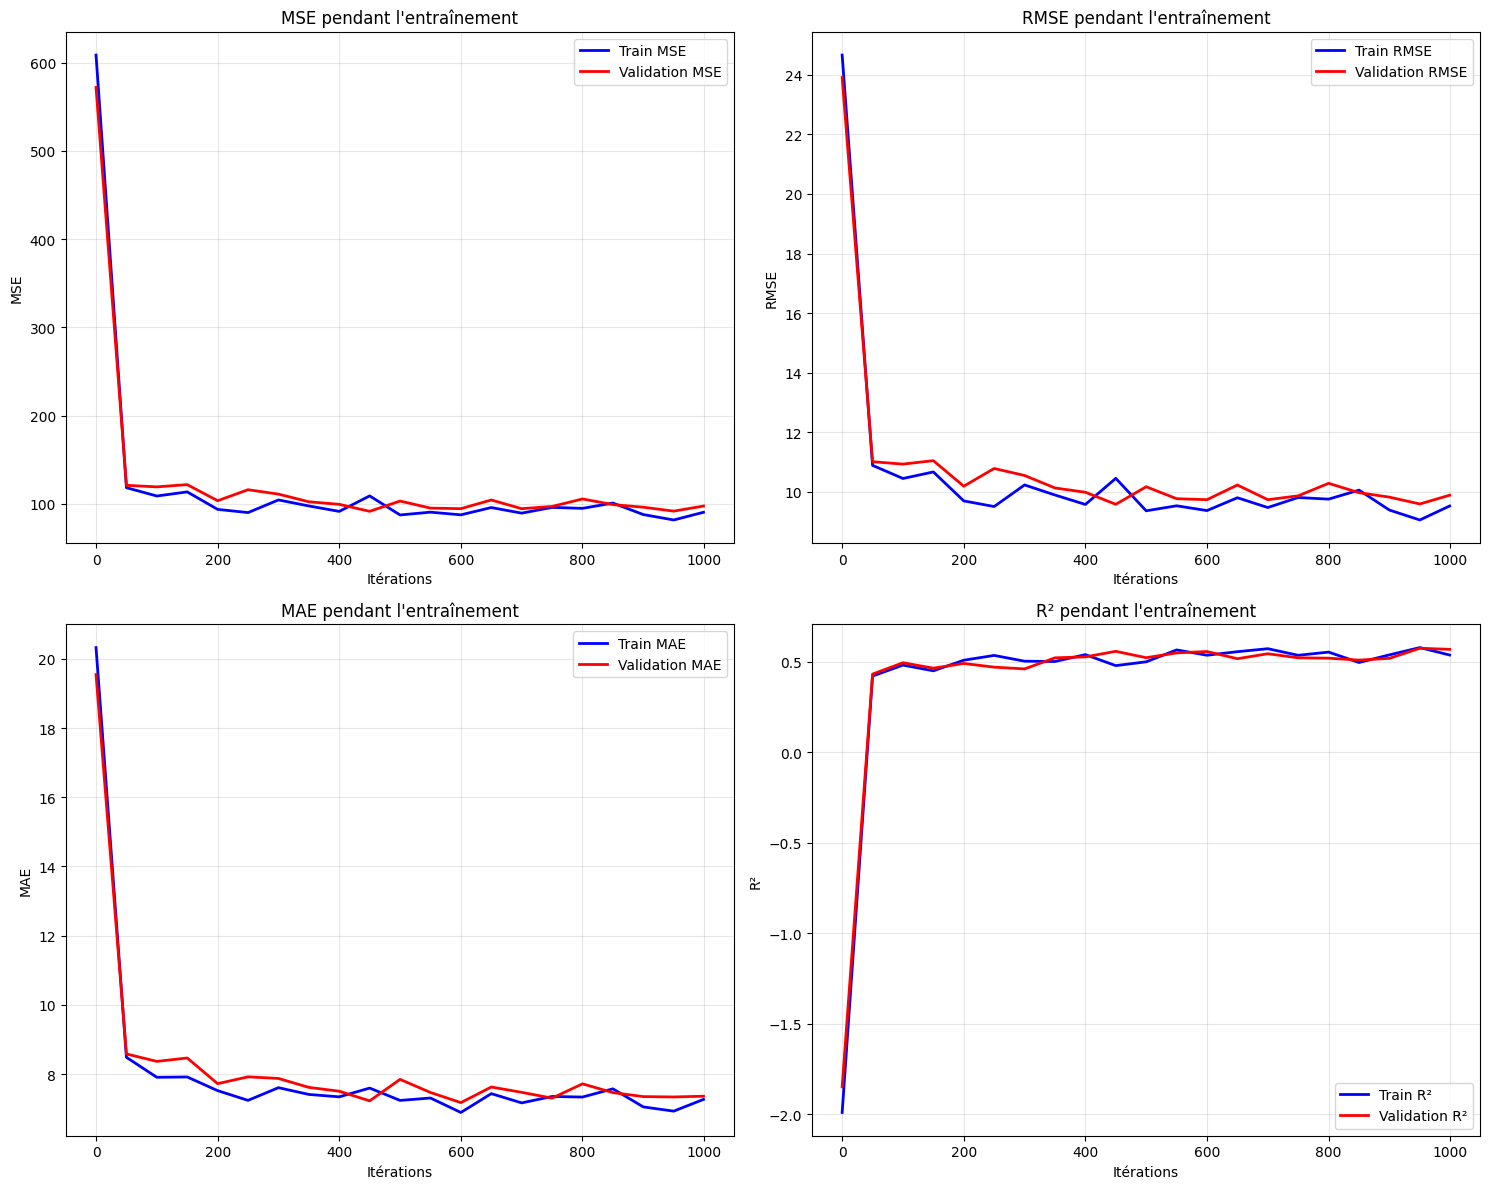


🚀 Analyse du modèle: Sans_Régularisation
🔧 Construction du modèle...


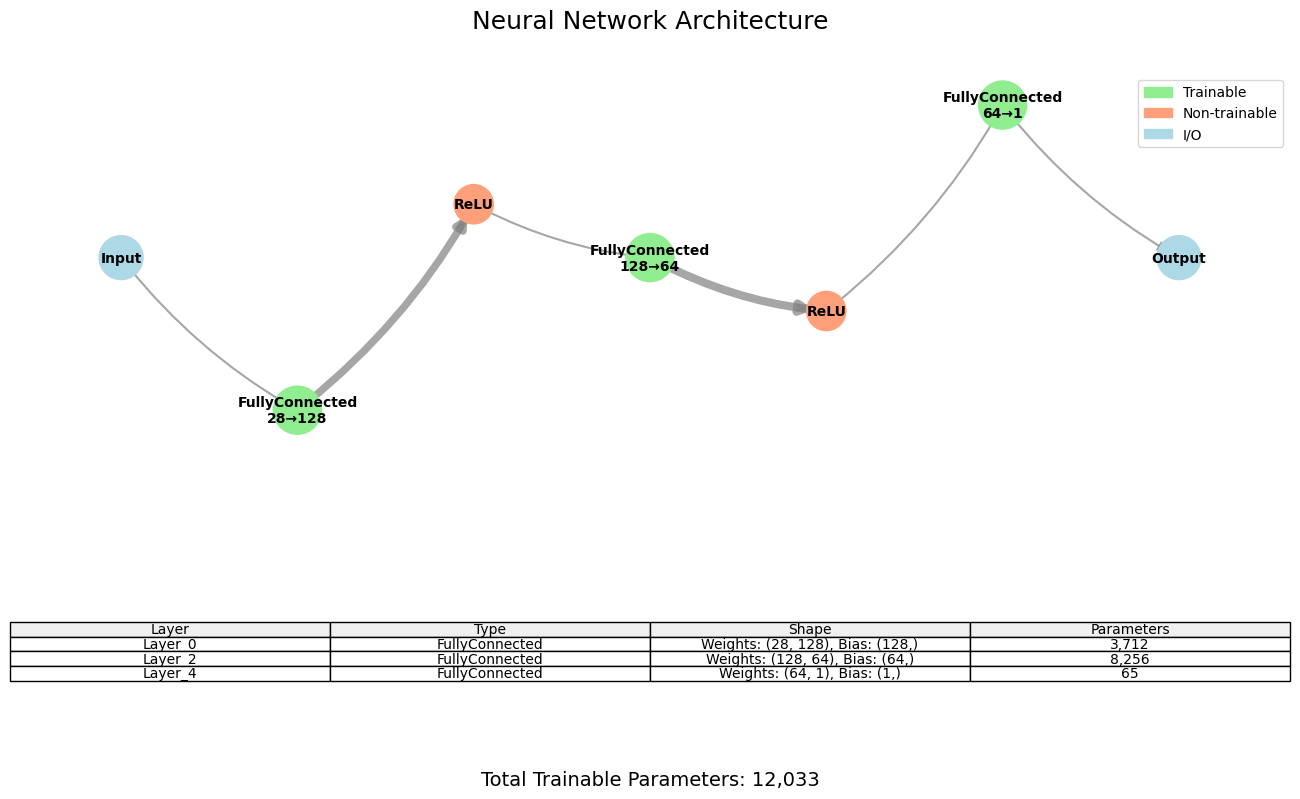

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   713.616958 |     769.297193 |   762.624960 | 0.00s
        50 |   218.387539 |     249.460167 |   270.505602 | 0.03s
       100 |   163.254416 |     164.927641 |   156.793406 | 0.07s
       150 |   103.418319 |     138.674127 |   133.735342 | 0.09s
       200 |   161.849171 |     110.933931 |   112.616143 | 0.12s
       250 |    93.526166 |     117.740391 |   117.933886 | 0.15s
       300 |   111.358311 |     112.212478 |   114.348947 | 0.18s
       350 |   134.932704 |      99.090955 |   102.368940 | 0.21s
       400 |   114.221962 |     105.314186 |   102.966590 | 0.24s
       450 |    94.921476 |     105.341851 |   103.230374 | 0.28s
       500 |    55.456094 | 

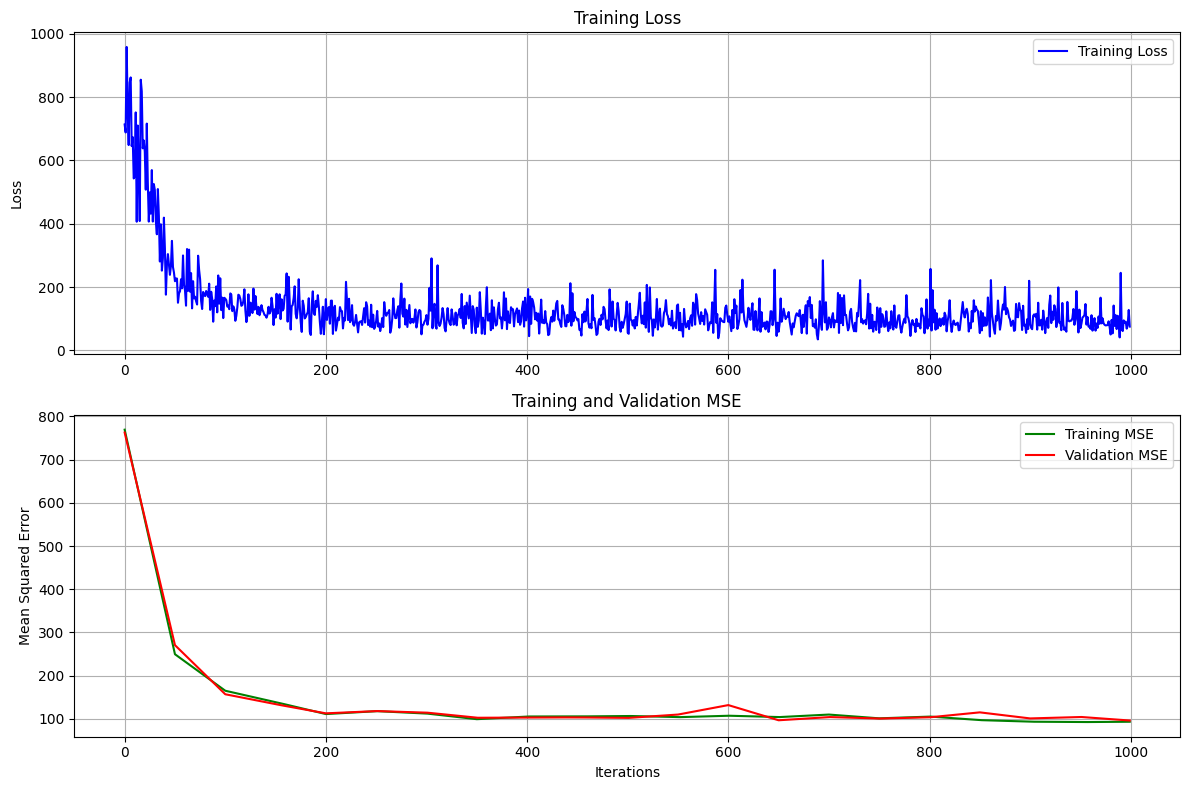

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 97.9649
RMSE: 9.8977
MAE: 7.4404
R²: 0.5114
Variance expliquée: 0.5135
📊 Génération des visualisations...


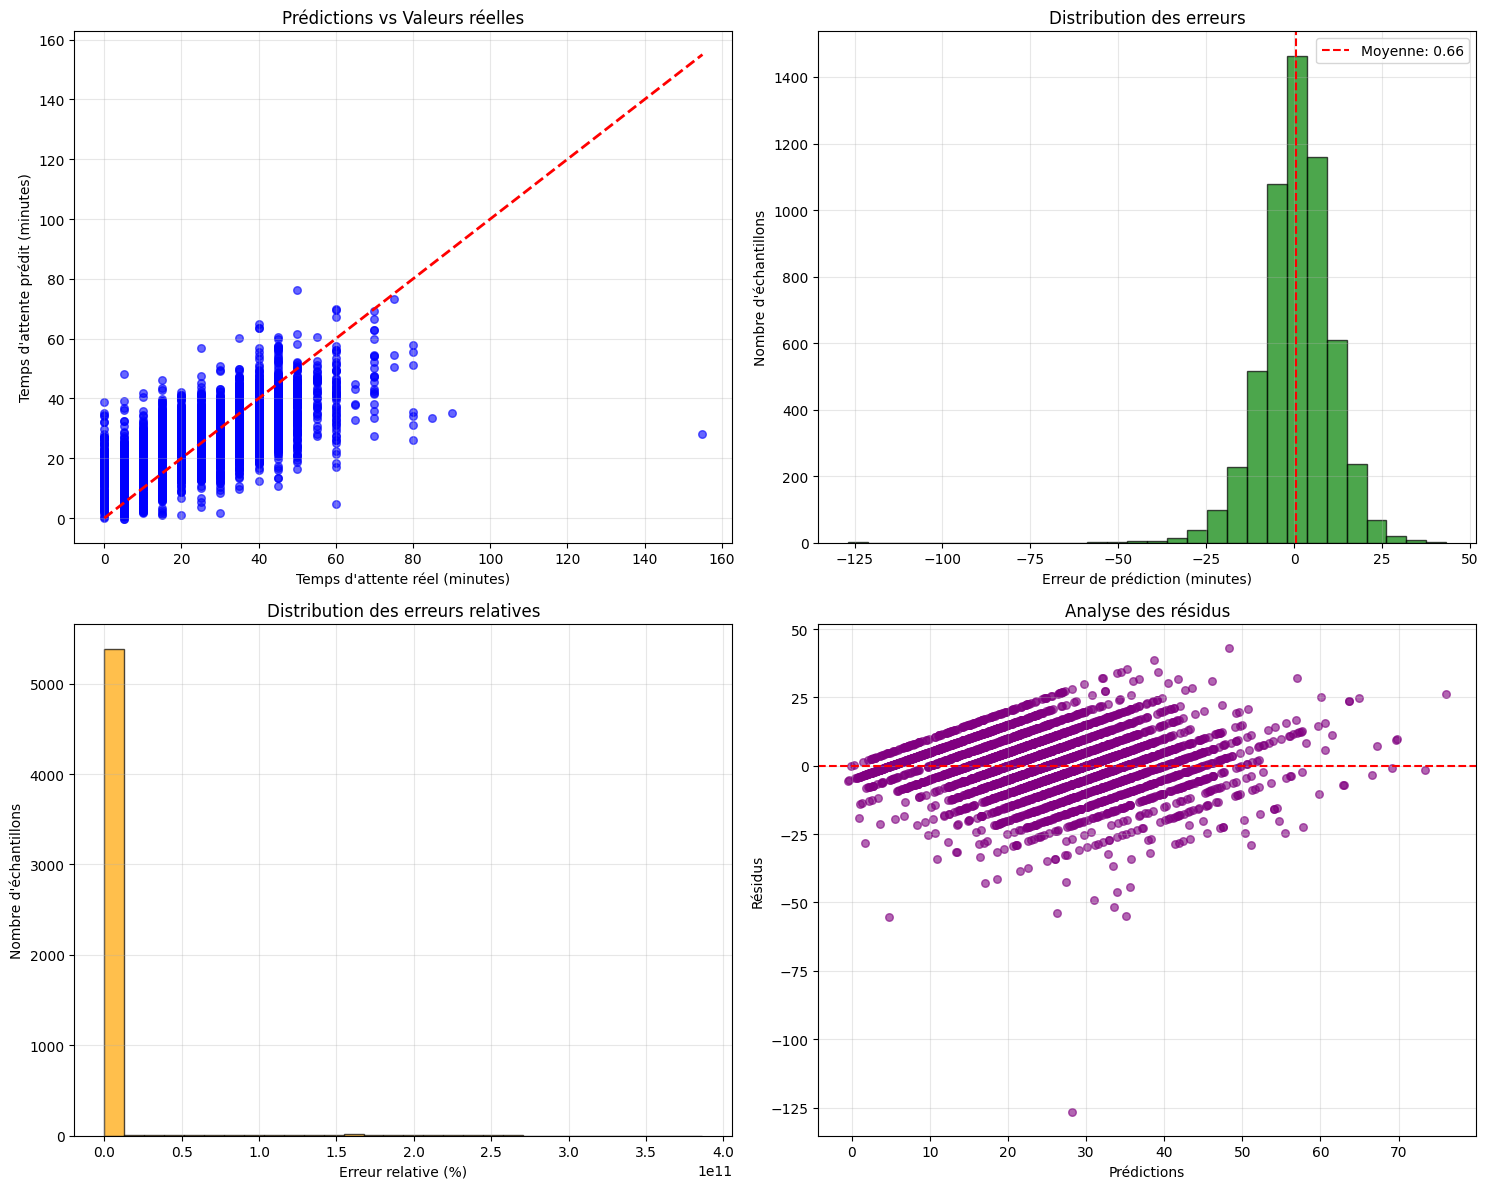

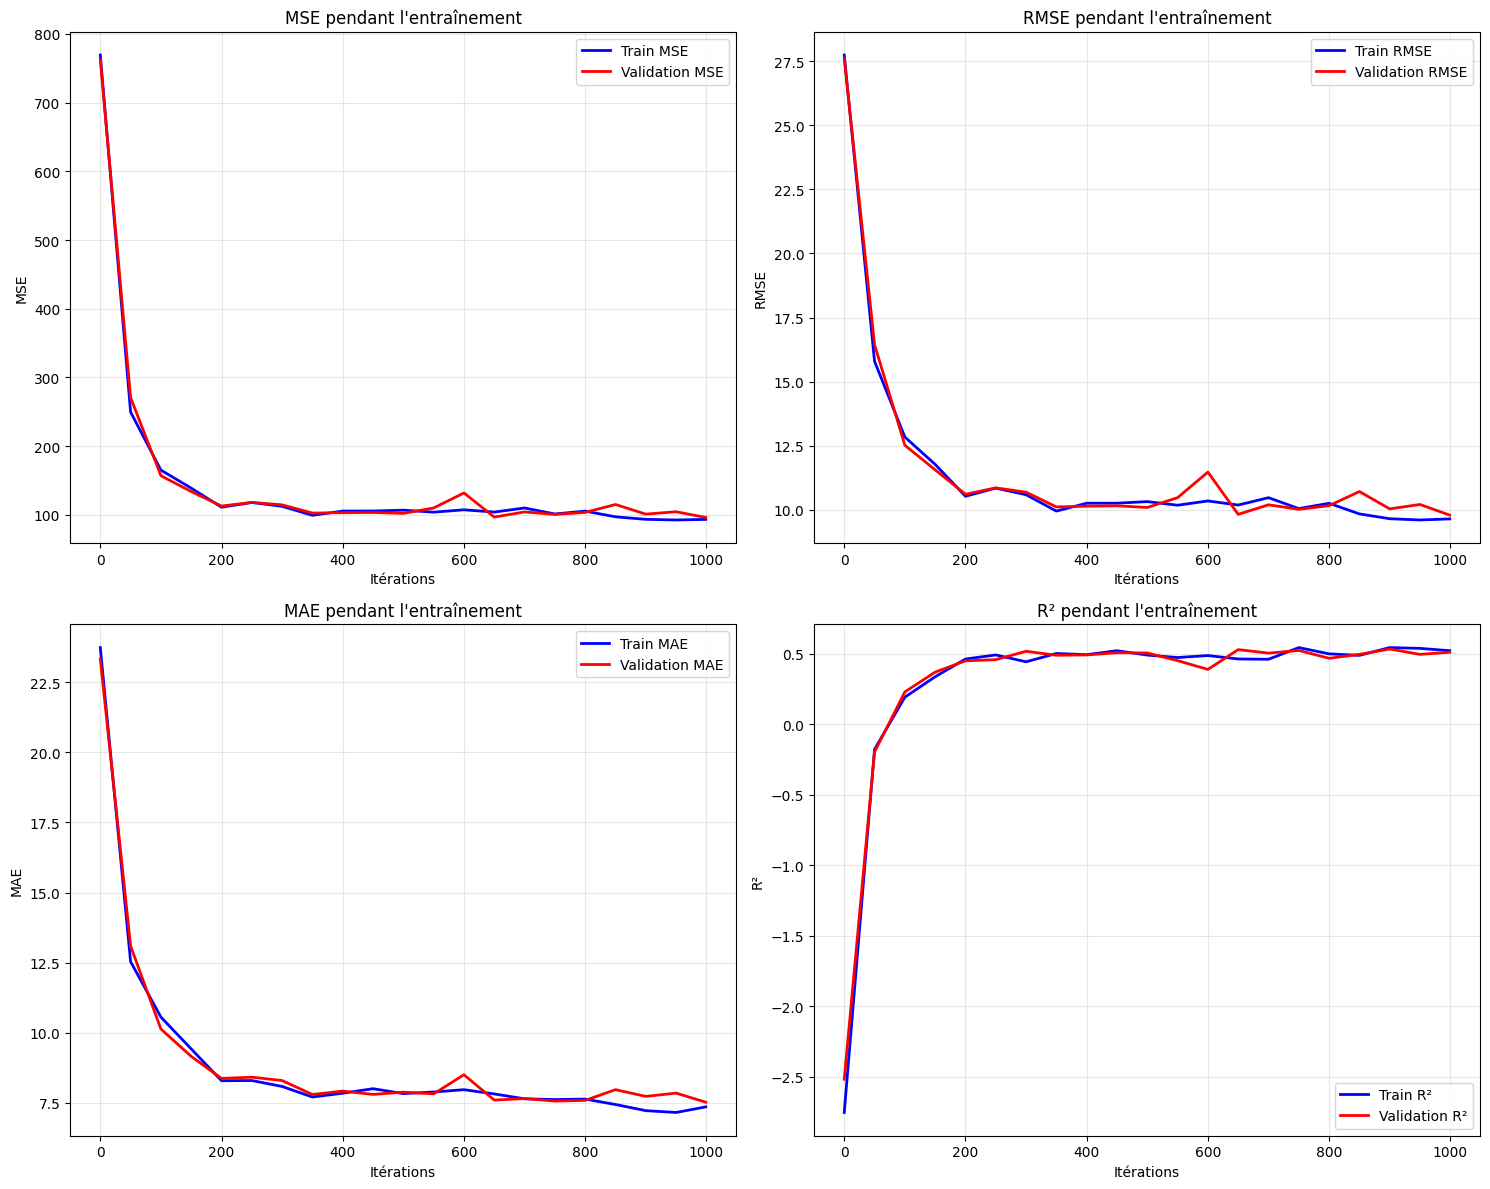


🚀 Analyse du modèle: Étroit_Profond
🔧 Construction du modèle...


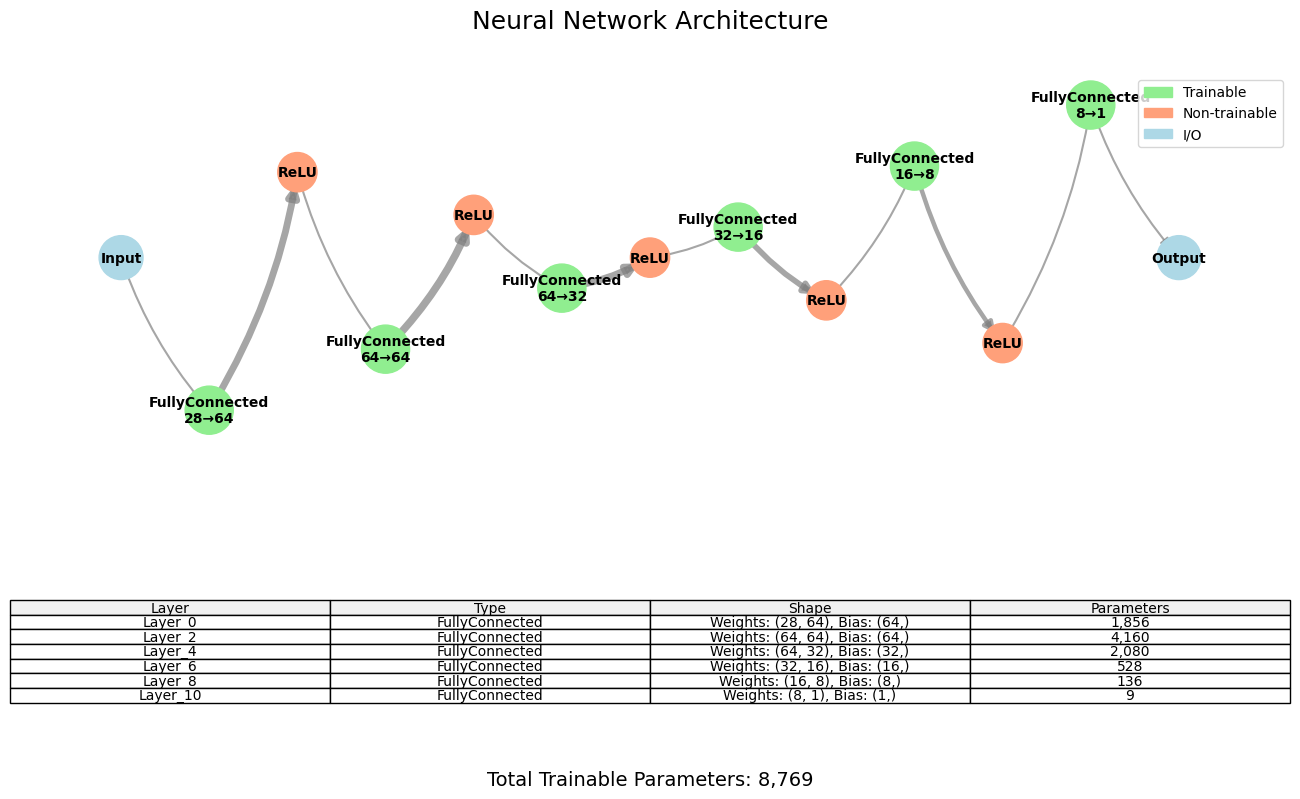

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   840.110436 |     743.879377 |   732.459487 | 0.00s
        50 |   202.880166 |     223.909643 |   245.727840 | 0.05s
       100 |   171.403710 |     159.615049 |   163.026568 | 0.10s
       150 |   222.806703 |     129.563885 |   126.553587 | 0.14s
       200 |   105.933011 |     113.977910 |   112.352210 | 0.18s
       250 |   240.062338 |      96.917293 |   105.005193 | 0.22s
       300 |    68.044923 |     108.034314 |   100.982529 | 0.30s
       350 |    73.645664 |     105.651424 |   101.115746 | 0.35s
       400 |   106.793822 |      92.673480 |   105.111647 | 0.39s
       450 |    57.509810 |     100.889316 |   111.224286 | 0.43s
       500 |   101.294618 | 

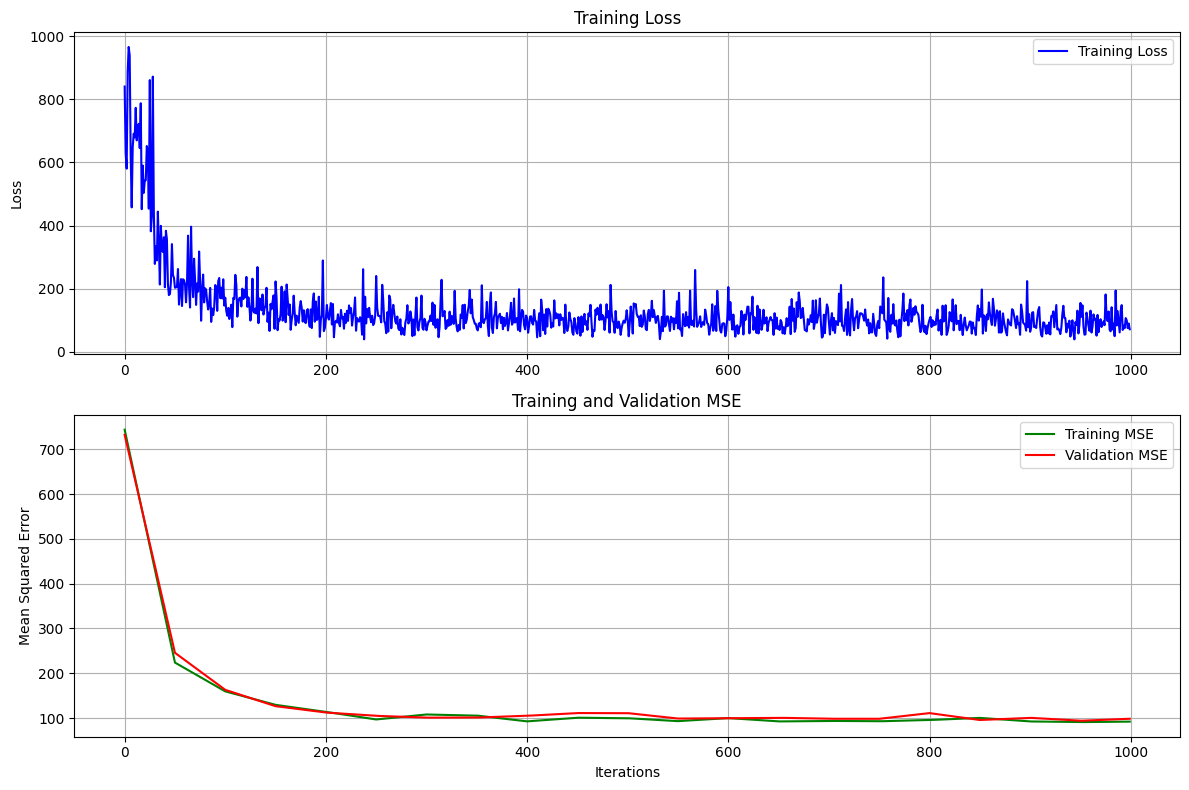

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 96.2090
RMSE: 9.8086
MAE: 7.2078
R²: 0.5201
Variance expliquée: 0.5235
📊 Génération des visualisations...


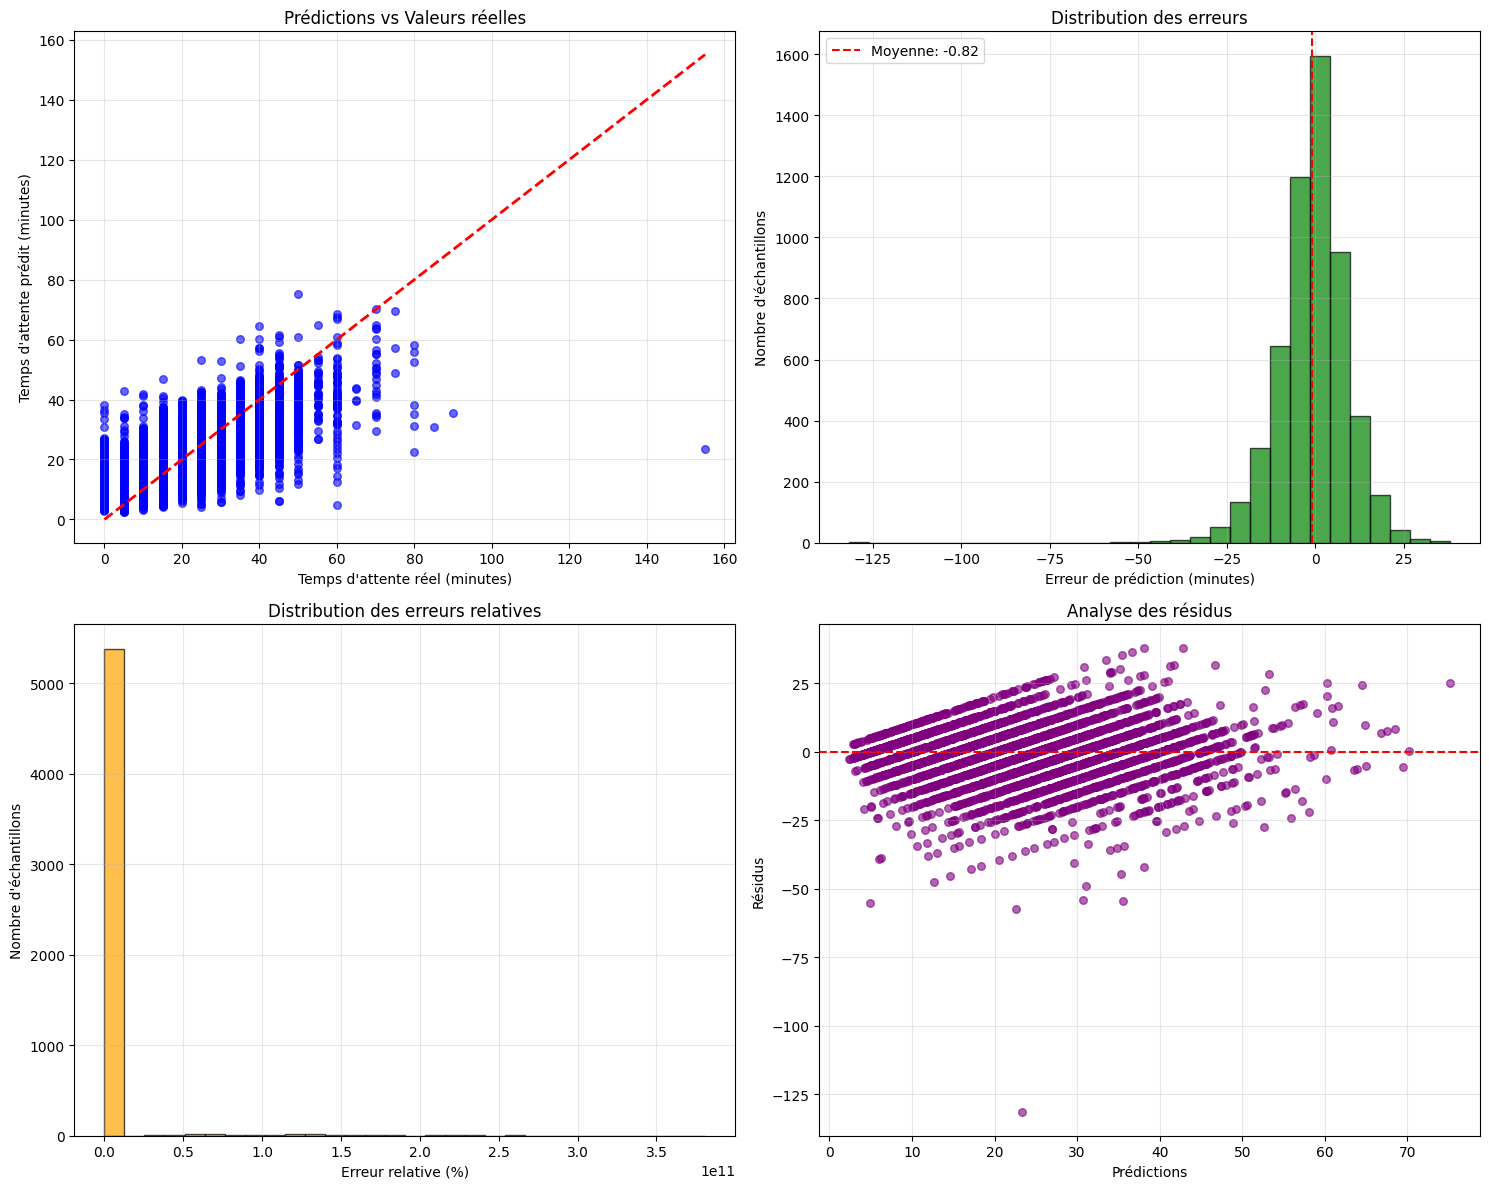

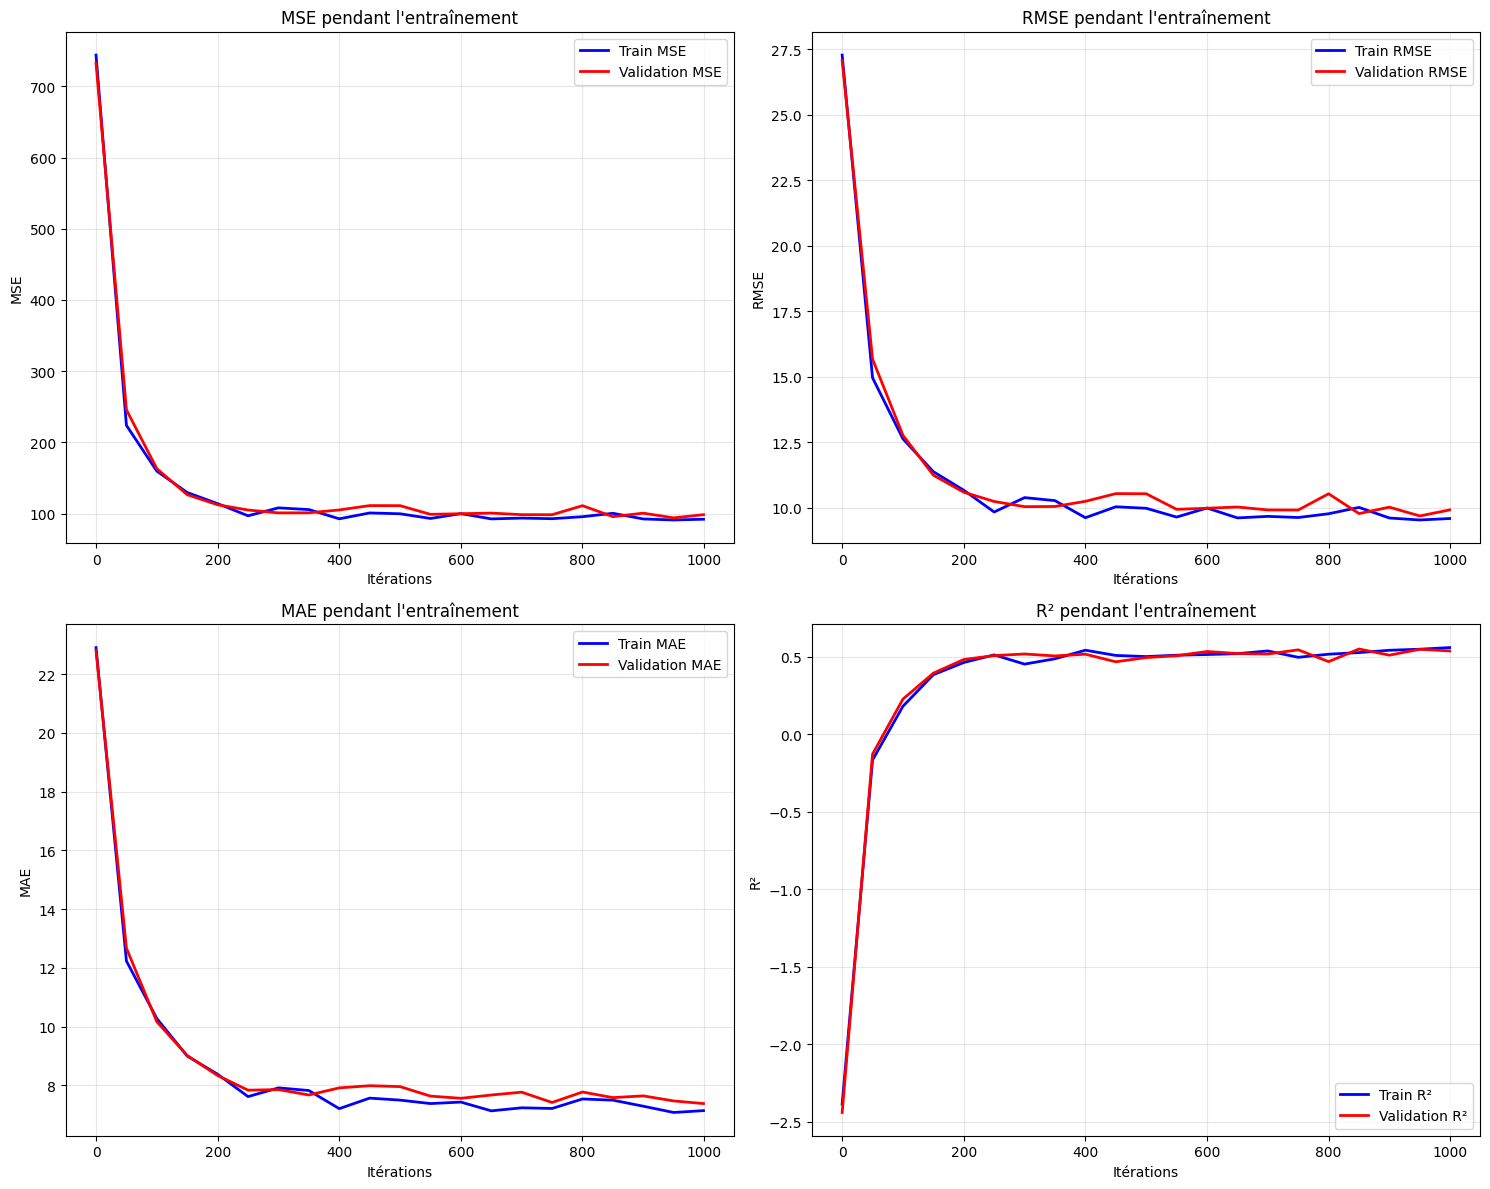


🚀 Analyse du modèle: Ensemble_Ready
🔧 Construction du modèle...


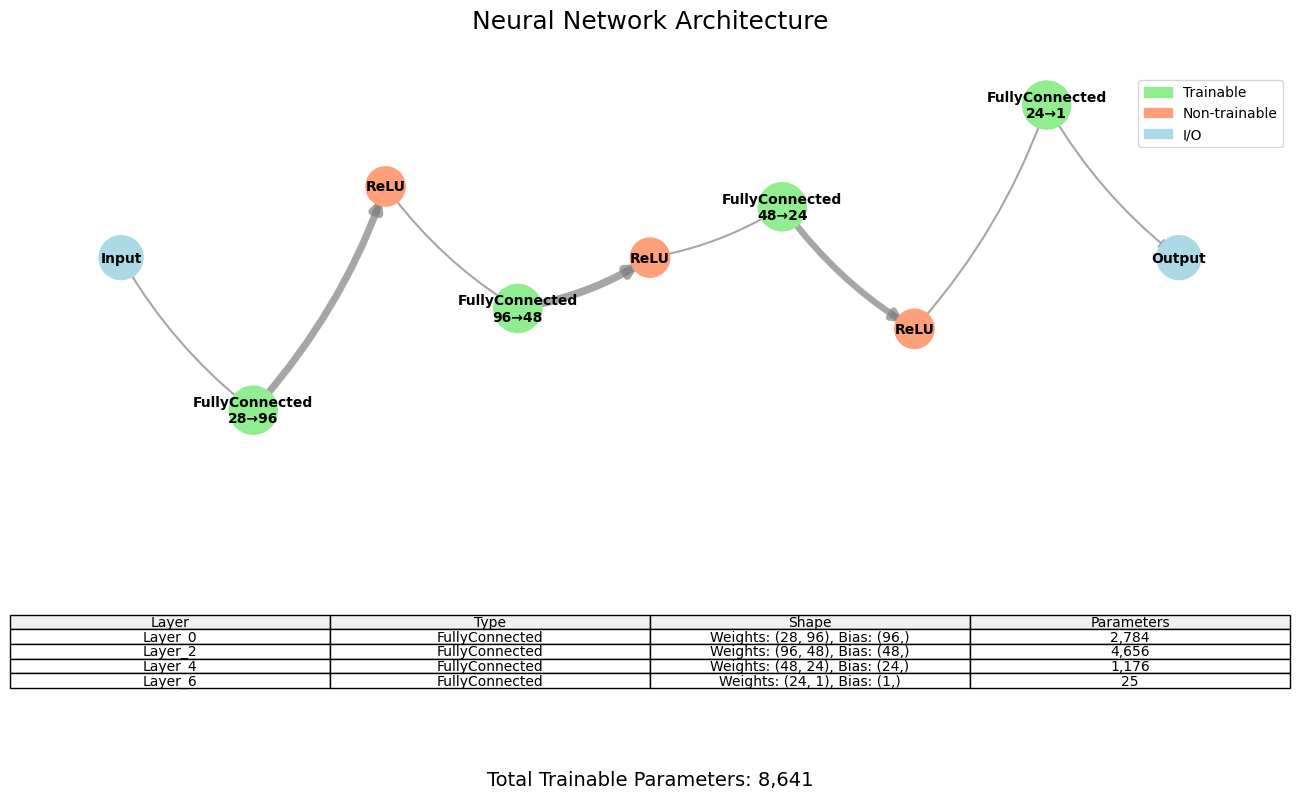

📊 Entraînement du modèle (1000 itérations)...
Détection automatique du type de problème: regression (basé sur MSELoss)
Validation set detected and will be used for display.
 Iteration |         Loss |      Train MSE |      Val MSE | Elapsed Time
-----------------------------------------------------------------
         0 |   949.671055 |     720.787307 |   754.528401 | 0.00s
        50 |   134.900671 |     167.489085 |   152.721892 | 0.06s
       100 |   216.070084 |     127.342068 |   125.585333 | 0.12s
       150 |    61.860364 |     117.014441 |   117.025338 | 0.17s
       200 |   111.023667 |     112.522394 |   114.513790 | 0.24s
       250 |   104.133204 |     105.121540 |   106.405303 | 0.30s
       300 |    79.657580 |      94.278854 |   106.690698 | 0.36s
       350 |    82.229679 |      96.166169 |    99.278609 | 0.41s
       400 |    51.832442 |     101.931249 |   110.195223 | 0.50s
       450 |    91.549418 |      95.136867 |   106.641624 | 0.56s
       500 |   101.484337 | 

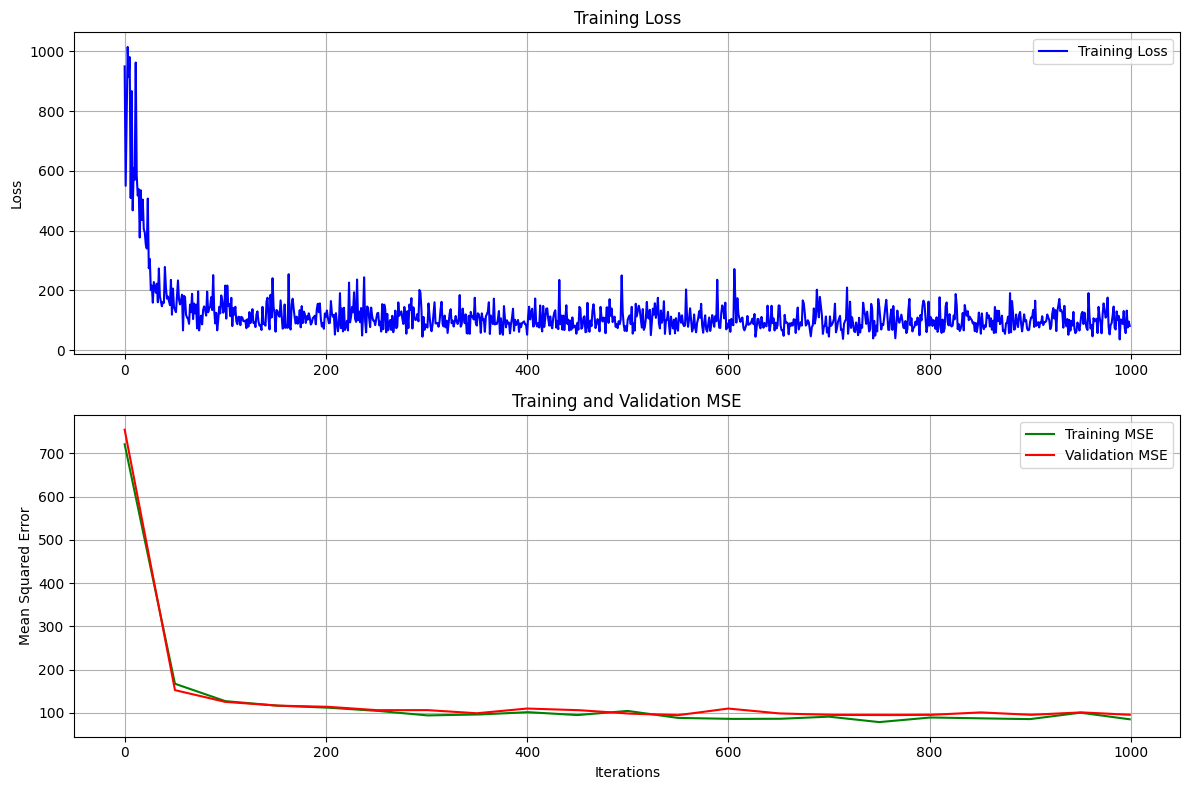

🎯 Évaluation sur l'ensemble de test...

📈 Métriques sur l'ensemble de test:
MSE: 93.0404
RMSE: 9.6457
MAE: 7.1215
R²: 0.5359
Variance expliquée: 0.5359
📊 Génération des visualisations...


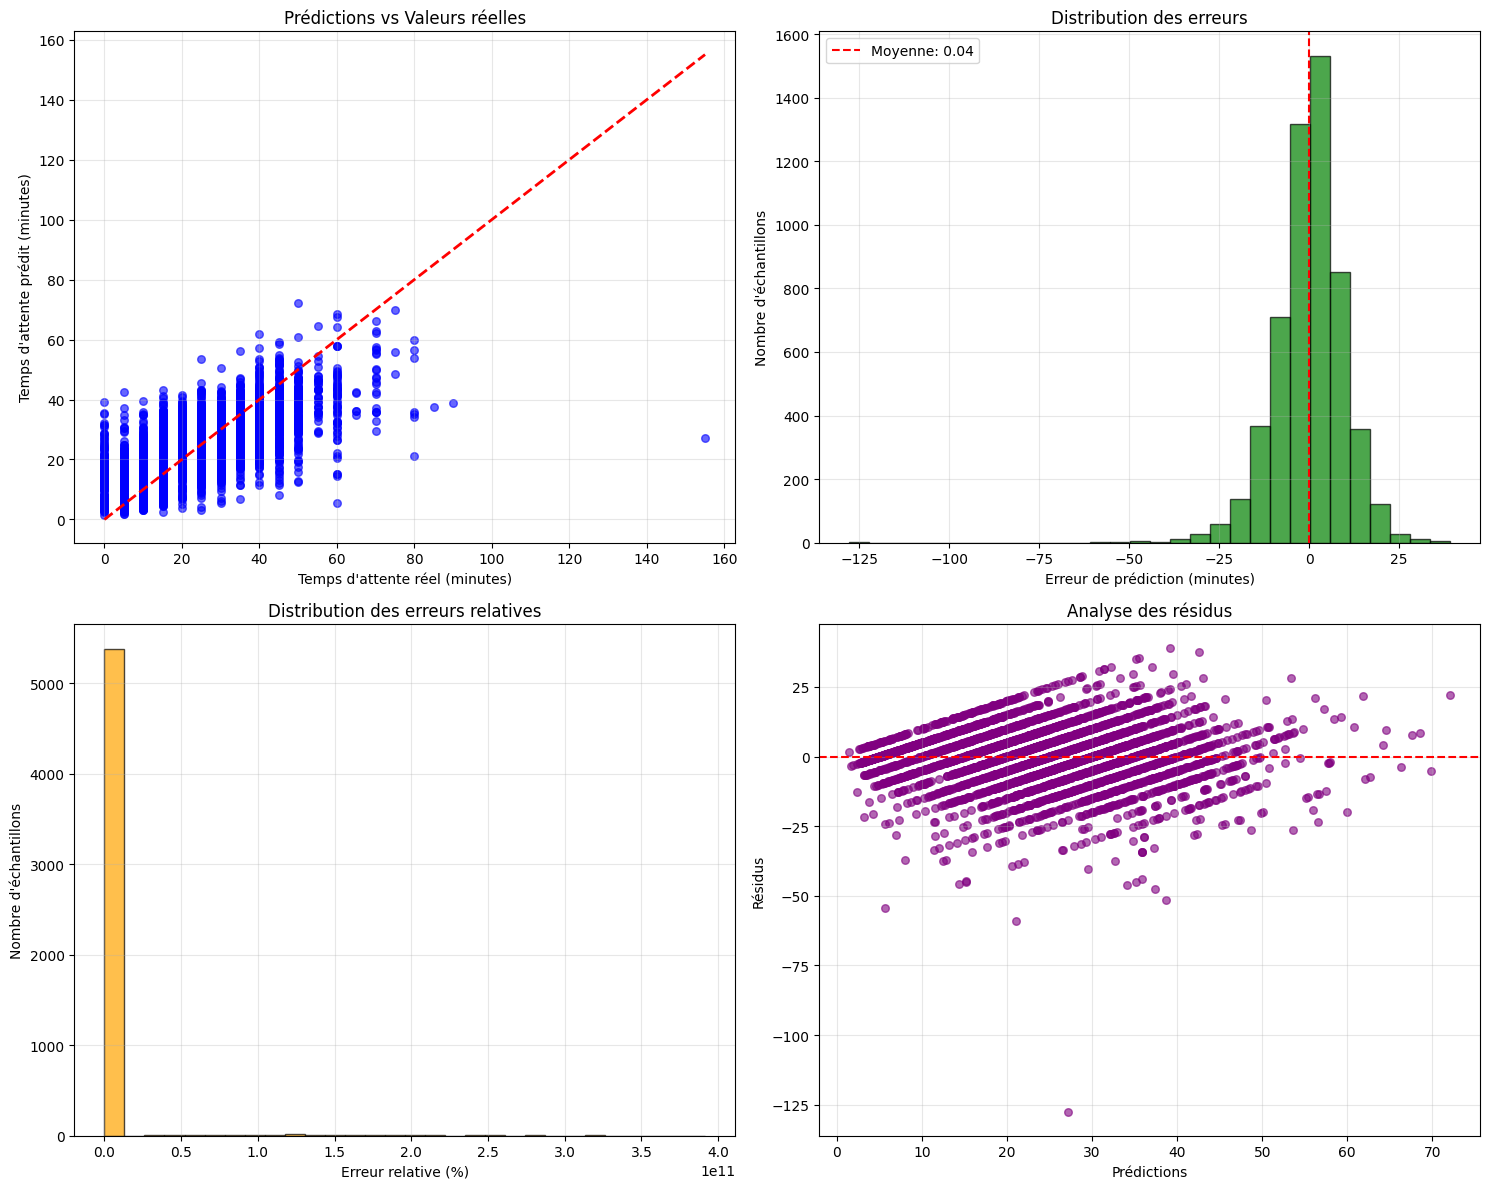

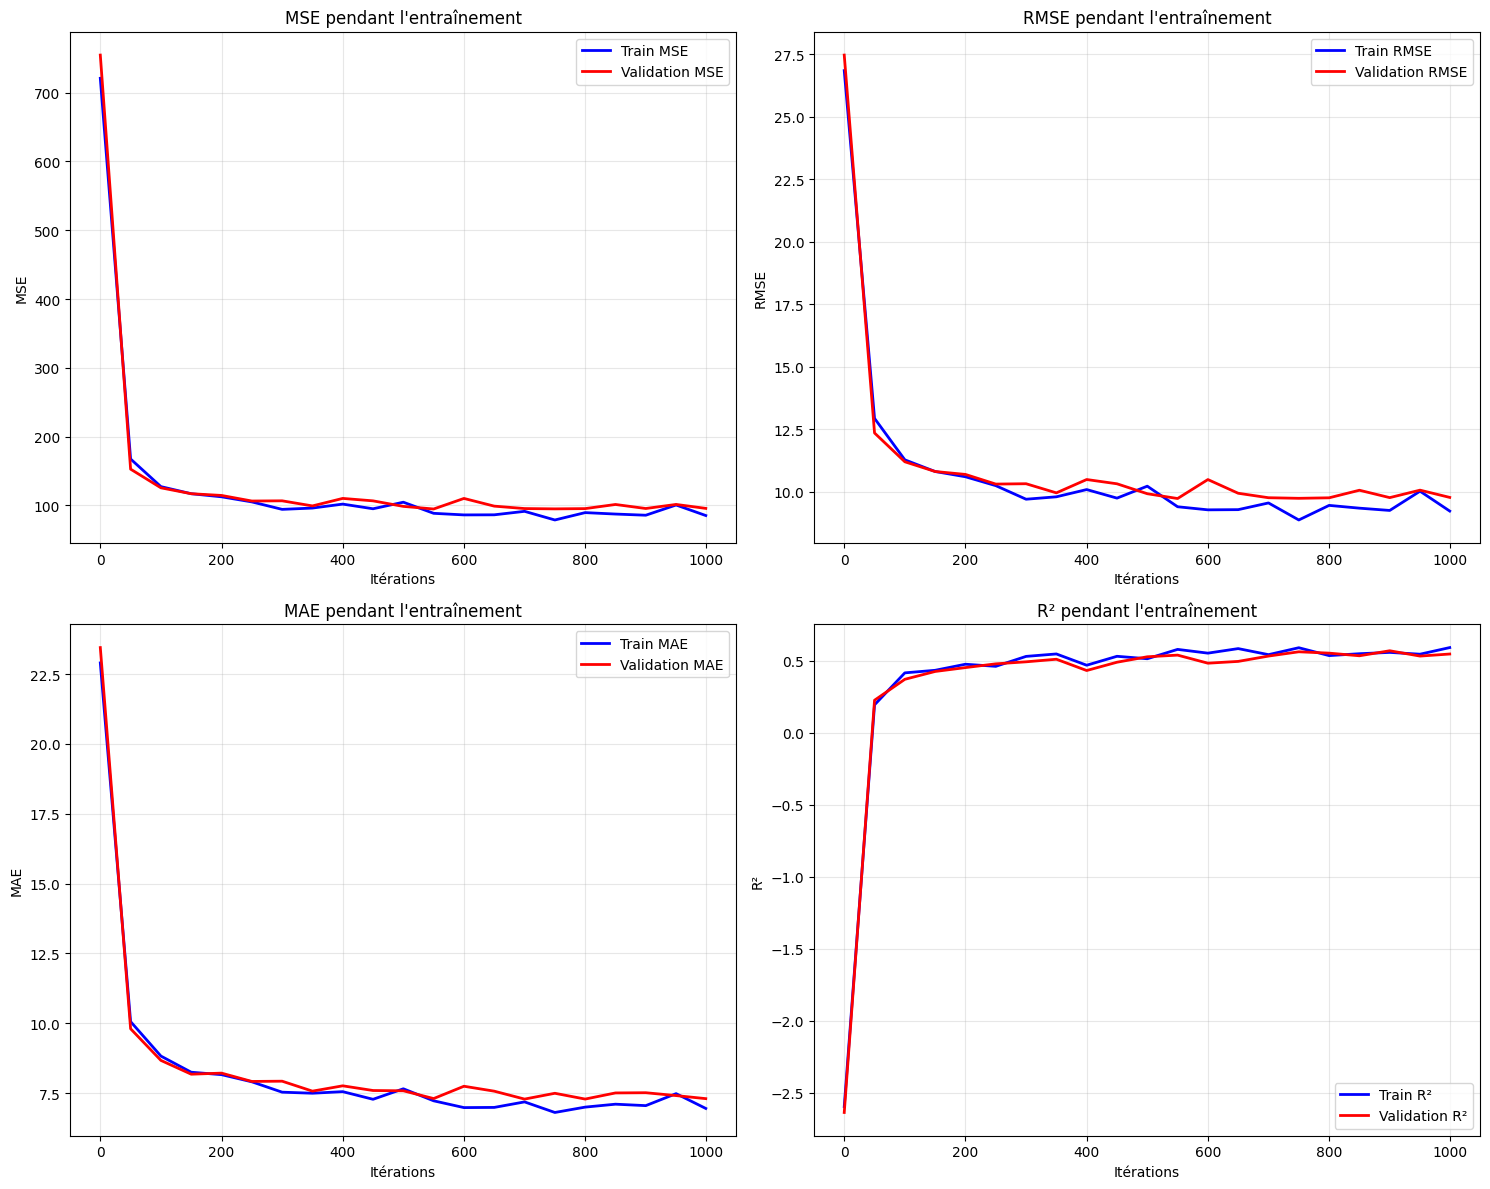


📊 TABLEAU COMPARATIF DES MODÈLES
Modèle               MSE        RMSE       MAE        R²         Var. Exp. 
--------------------------------------------------------------------------------
Simple_Léger         96.5215    9.8245     7.2539     0.5186     0.5331    
Profond_Large        95.1664    9.7553     7.0860     0.5253     0.5391    
Dropout_Robuste      352.0299   18.7625    14.9025    -0.7559    0.2372    
Tanh_Centré          102.8364   10.1408    7.4318     0.4871     0.4893    
Apprentissage_Rapide 94.6206    9.7273     7.1655     0.5280     0.5412    
Sans_Régularisation  97.9649    9.8977     7.4404     0.5114     0.5135    
Étroit_Profond       96.2090    9.8086     7.2078     0.5201     0.5235    
Ensemble_Ready       93.0404    9.6457     7.1215     0.5359     0.5359    


In [ ]:
results_dropout = analyze_and_visualize_regression_model(
    model_builder=build_dropout_robust_model,
    waitpark_data=waitpark,
    iterations=1000,
    plot_prefix="dropout_model"
)

REGRESSION_MODEL_VARIANTS = {
    'Simple_Léger': build_simple_shallow_model,
    'Profond_Large': build_deep_wide_model,
    'Dropout_Robuste': build_dropout_robust_model,
    # 'LeakyReLU_Stable': build_leaky_relu_model,
    'Tanh_Centré': build_tanh_model,
    'Apprentissage_Rapide': build_high_learning_rate_model,
    'Sans_Régularisation': build_no_regularization_model,
    'Étroit_Profond': build_narrow_deep_model,
    'Ensemble_Ready': build_ensemble_friendly_model
}

comparison = compare_regression_models(
    model_builders=REGRESSION_MODEL_VARIANTS,
    waitpark_data=waitpark,
    iterations=1000
)